In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No OBV CNN Images Experiments - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-noncyclic Stocks

##kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


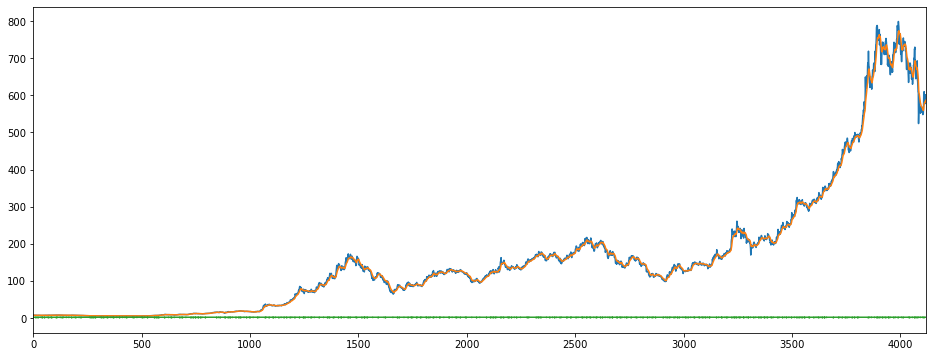

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0

In [8]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4106, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4106, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4106, 15, 1)

In [12]:
#obv_data = np.array(#obv_data)
#obv_data.shape

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4106, 64, 64, 1)

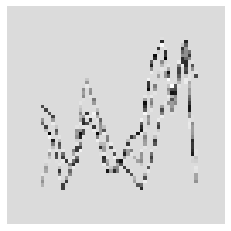

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.6142 - accuracy: 0.6250 - mse: 5.6207 - weighted_accuracy: 0.2370 - weighted_mse: 7.1989WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 34ms/step - loss: 0.2561 - accuracy: 0.3130 - mse: 1.7973 - weighted_accuracy: 0.3236 - weighted_mse: 1.9093 - val_loss: 0.1903 - val_accuracy: 0.6046 - val_mse: 0.8588 - val_weighted_accuracy: 0.6046 - val_weighted_mse: 0.8588
Epoch 2/200
26/26 [==============================] - 0s 15ms/step - loss: 0.2054 - accuracy: 0.2801 - mse: 1.2422 - weighted_accuracy: 0.3514 - weighted_mse: 1.2331 - val_loss: 0.2023 - val_accuracy: 0.0450 - va

Epoch 27/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1974 - accuracy: 0.2558 - mse: 1.1867 - weighted_accuracy: 0.3480 - weighted_mse: 1.1661 - val_loss: 0.1983 - val_accuracy: 0.0718 - val_mse: 1.0430 - val_weighted_accuracy: 0.0718 - val_weighted_mse: 1.0430
Epoch 28/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1977 - accuracy: 0.2567 - mse: 1.2311 - weighted_accuracy: 0.3808 - weighted_mse: 1.1980 - val_loss: 0.1969 - val_accuracy: 0.0669 - val_mse: 0.9389 - val_weighted_accuracy: 0.0669 - val_weighted_mse: 0.9389
Epoch 29/200
26/26 [==============================] - 0s 19ms/step - loss: 0.1981 - accuracy: 0.2564 - mse: 1.1784 - weighted_accuracy: 0.3437 - weighted_mse: 1.1692 - val_loss: 0.2008 - val_accuracy: 0.0693 - val_mse: 0.9915 - val_weighted_accuracy: 0.0693 - val_weighted_mse: 0.9915
Epoch 30/200
26/26 [==============================] - 0s 18ms/step - loss: 0.1958 - accuracy: 0.2375 - mse: 1.2205 - weighted_accuracy: 0.4019 - 

Epoch 56/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1779 - accuracy: 0.1574 - mse: 1.3271 - weighted_accuracy: 0.5516 - weighted_mse: 1.2853 - val_loss: 0.1990 - val_accuracy: 0.0730 - val_mse: 1.0738 - val_weighted_accuracy: 0.0730 - val_weighted_mse: 1.0738
Epoch 57/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1791 - accuracy: 0.1705 - mse: 1.3293 - weighted_accuracy: 0.5131 - weighted_mse: 1.2628 - val_loss: 0.1984 - val_accuracy: 0.0706 - val_mse: 1.1238 - val_weighted_accuracy: 0.0706 - val_weighted_mse: 1.1238
Epoch 58/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1779 - accuracy: 0.1535 - mse: 1.3414 - weighted_accuracy: 0.5306 - weighted_mse: 1.2851 - val_loss: 0.1987 - val_accuracy: 0.0754 - val_mse: 1.0729 - val_weighted_accuracy: 0.0754 - val_weighted_mse: 1.0729
Epoch 59/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1780 - accuracy: 0.1602 - mse: 1.3030 - weighted_accuracy: 0.5095 - 

Epoch 85/200
26/26 [==============================] - 0s 18ms/step - loss: 0.1647 - accuracy: 0.1657 - mse: 1.5047 - weighted_accuracy: 0.5869 - weighted_mse: 1.4442 - val_loss: 0.2034 - val_accuracy: 0.1119 - val_mse: 1.1192 - val_weighted_accuracy: 0.1119 - val_weighted_mse: 1.1192
Epoch 86/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1614 - accuracy: 0.1583 - mse: 1.4447 - weighted_accuracy: 0.5971 - weighted_mse: 1.3861 - val_loss: 0.2015 - val_accuracy: 0.1107 - val_mse: 1.2440 - val_weighted_accuracy: 0.1107 - val_weighted_mse: 1.2440
Epoch 87/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1616 - accuracy: 0.1644 - mse: 1.5008 - weighted_accuracy: 0.5952 - weighted_mse: 1.4521 - val_loss: 0.1984 - val_accuracy: 0.1314 - val_mse: 1.3020 - val_weighted_accuracy: 0.1314 - val_weighted_mse: 1.3020
Epoch 88/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1613 - accuracy: 0.1641 - mse: 1.4333 - weighted_accuracy: 0.6014 - 

Epoch 114/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1472 - accuracy: 0.2098 - mse: 1.6754 - weighted_accuracy: 0.6548 - weighted_mse: 1.7079 - val_loss: 0.1994 - val_accuracy: 0.1691 - val_mse: 1.3628 - val_weighted_accuracy: 0.1691 - val_weighted_mse: 1.3628
Epoch 115/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1444 - accuracy: 0.2141 - mse: 1.6383 - weighted_accuracy: 0.6735 - weighted_mse: 1.6698 - val_loss: 0.1975 - val_accuracy: 0.1837 - val_mse: 1.5436 - val_weighted_accuracy: 0.1837 - val_weighted_mse: 1.5436
Epoch 116/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1455 - accuracy: 0.2159 - mse: 1.7310 - weighted_accuracy: 0.6483 - weighted_mse: 1.7721 - val_loss: 0.1982 - val_accuracy: 0.1606 - val_mse: 1.4793 - val_weighted_accuracy: 0.1606 - val_weighted_mse: 1.4793
Epoch 117/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1451 - accuracy: 0.2180 - mse: 1.6666 - weighted_accuracy: 0.644

Epoch 143/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1327 - accuracy: 0.3426 - mse: 1.9833 - weighted_accuracy: 0.7225 - weighted_mse: 2.1494 - val_loss: 0.1917 - val_accuracy: 0.2847 - val_mse: 1.7995 - val_weighted_accuracy: 0.2847 - val_weighted_mse: 1.7995
Epoch 144/200
26/26 [==============================] - 0s 18ms/step - loss: 0.1335 - accuracy: 0.3149 - mse: 2.0029 - weighted_accuracy: 0.6997 - weighted_mse: 2.1645 - val_loss: 0.1950 - val_accuracy: 0.2908 - val_mse: 1.7564 - val_weighted_accuracy: 0.2908 - val_weighted_mse: 1.7564
Epoch 145/200
26/26 [==============================] - 0s 17ms/step - loss: 0.1325 - accuracy: 0.3404 - mse: 1.9552 - weighted_accuracy: 0.7090 - weighted_mse: 2.1773 - val_loss: 0.1895 - val_accuracy: 0.2920 - val_mse: 1.7131 - val_weighted_accuracy: 0.2920 - val_weighted_mse: 1.7131
Epoch 146/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1326 - accuracy: 0.3316 - mse: 2.0147 - weighted_accuracy: 0.714

Epoch 172/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1204 - accuracy: 0.4823 - mse: 2.3596 - weighted_accuracy: 0.7524 - weighted_mse: 2.8611 - val_loss: 0.1771 - val_accuracy: 0.4647 - val_mse: 2.0200 - val_weighted_accuracy: 0.4647 - val_weighted_mse: 2.0200
Epoch 173/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1185 - accuracy: 0.4805 - mse: 2.3707 - weighted_accuracy: 0.7668 - weighted_mse: 2.8766 - val_loss: 0.1617 - val_accuracy: 0.5535 - val_mse: 2.0181 - val_weighted_accuracy: 0.5535 - val_weighted_mse: 2.0181
Epoch 174/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1221 - accuracy: 0.4823 - mse: 2.3892 - weighted_accuracy: 0.7567 - weighted_mse: 2.7573 - val_loss: 0.1740 - val_accuracy: 0.4745 - val_mse: 1.9410 - val_weighted_accuracy: 0.4745 - val_weighted_mse: 1.9410
Epoch 175/200
26/26 [==============================] - 0s 16ms/step - loss: 0.1177 - accuracy: 0.4948 - mse: 2.3772 - weighted_accuracy: 0.776

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15994782745838165
Test accuracy: 0.5888077616691589


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.67645645 -1.6163273  -0.48098215]
 [-3.3893206   0.14185268 -0.7542015 ]
 [-0.88791996 -1.581296   -0.54405856]
 ...
 [-0.60515696 -1.7399106  -0.48603103]
 [-0.20999363 -2.1210182  -0.61789024]
 [-2.725872   -0.14743373 -0.5855403 ]]


Counter({2: 505, 1: 139, 0: 178})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 822
actual predicted buys: 10
actual buys but predicted sell: 1
actual buys but predicted hold: 26
actual sells but predicted buy: 0
actual predicted sells: 16
actual sells but predicted hold: 21
actual holds but predicted buy: 129
actual holds but predicted sell: 161
actual predicted holds: 458
Percentage buys correct: 27.027027027027028%
Percentage sells correct: 43.24324324324324%
Percentage holds correct: 61.22994652406417%
actual buys: 37
actual sells: 37
actual holds: 748


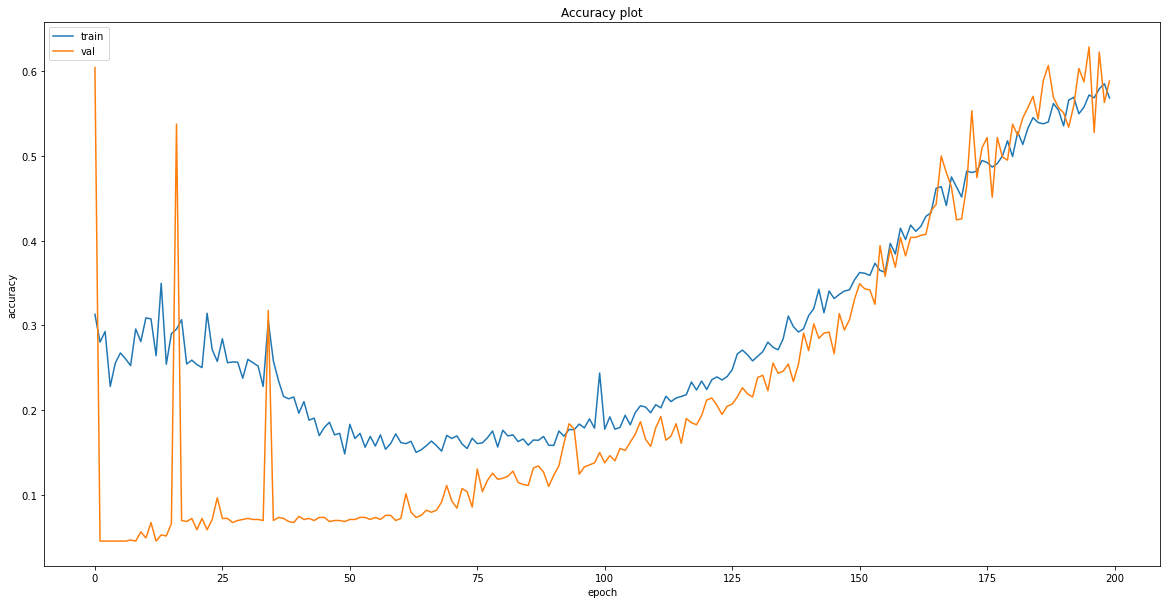

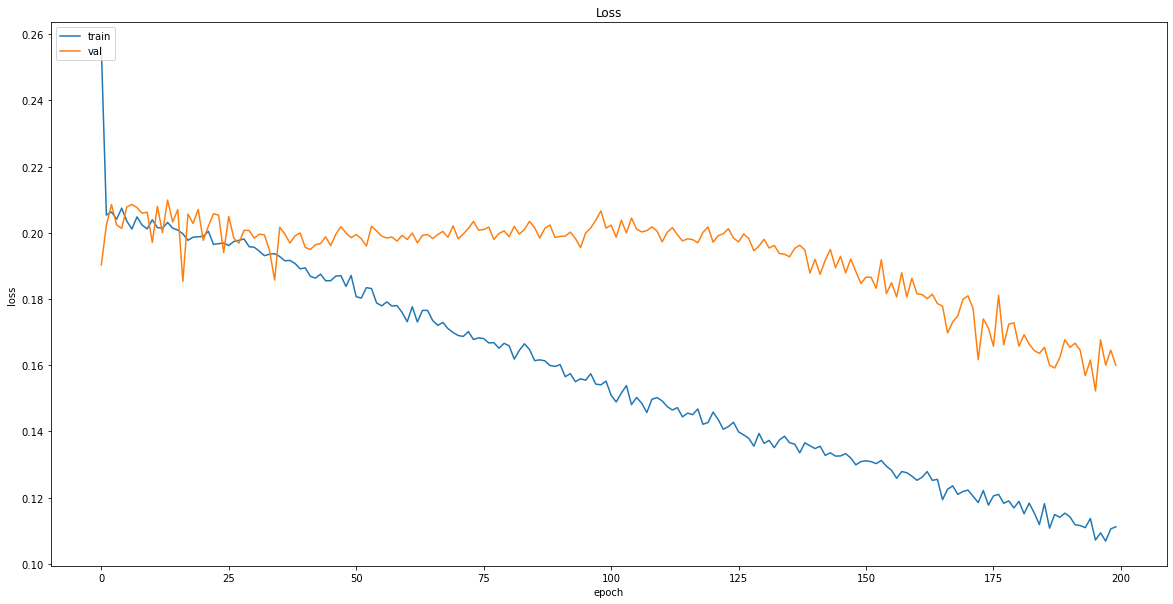

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('moutai_image_cnn_buy_hold_sell_no_obv.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0


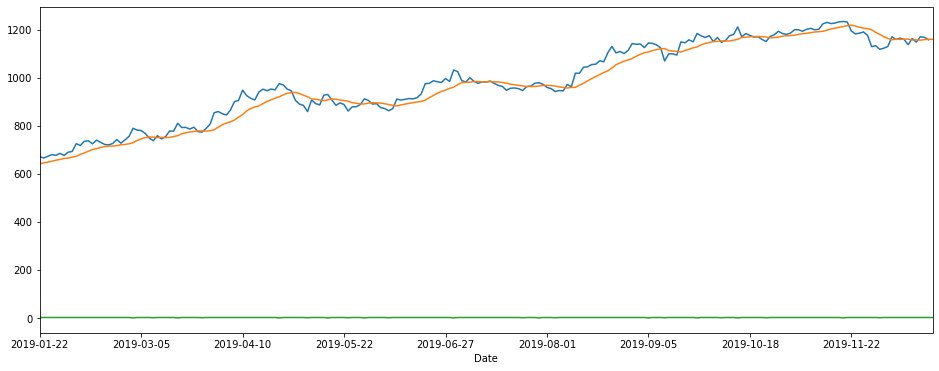

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# #obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# #data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         #data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         #obv_data.append(#data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         #data_15_obv = #data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         #data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1647 - accuracy: 0.5411 - mean_squared_error: 2.5001 - weighted_accuracy: 0.5411 - weighted_mean_squared_error: 2.5001
Test loss: 0.16473248600959778
Test accuracy: 0.5410627722740173


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 124, 0: 53, 1: 30})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [40]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2019-02-18    740.00000  704.389763 -23.444619  43919901.0     2.0   
2019-02-19    730.76001  709.868261  -6.049880  47694490.0     2.0   
2019-02-20    722.00000  713.082376 -17.677836  44744340.0     2.0   
2019-02-21    720.25000  714.454318 -29.824573  40956103.0     2.0   
2019-02-22    726.01001  715.345962 -32.098776  37971063.0     2.0   

            predictions  actual  
Date                             
2019-02-18            2       2  
2019-02-19            0       2  
2019-02-20            2       2  
2019-02-21            2       2  
2019-02-22            2       2

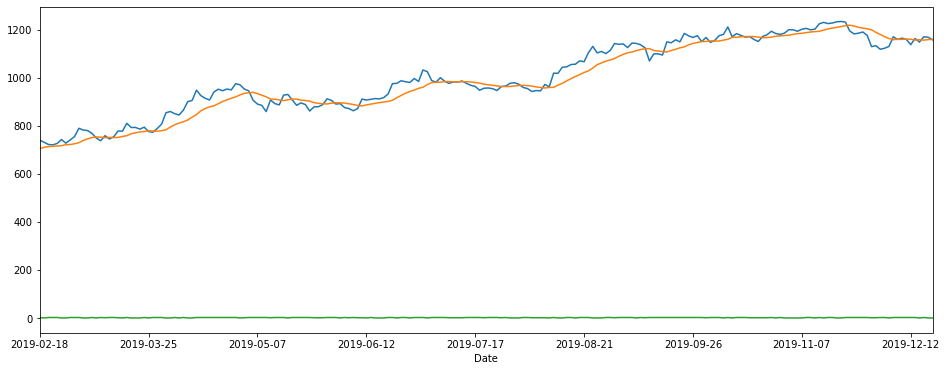

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

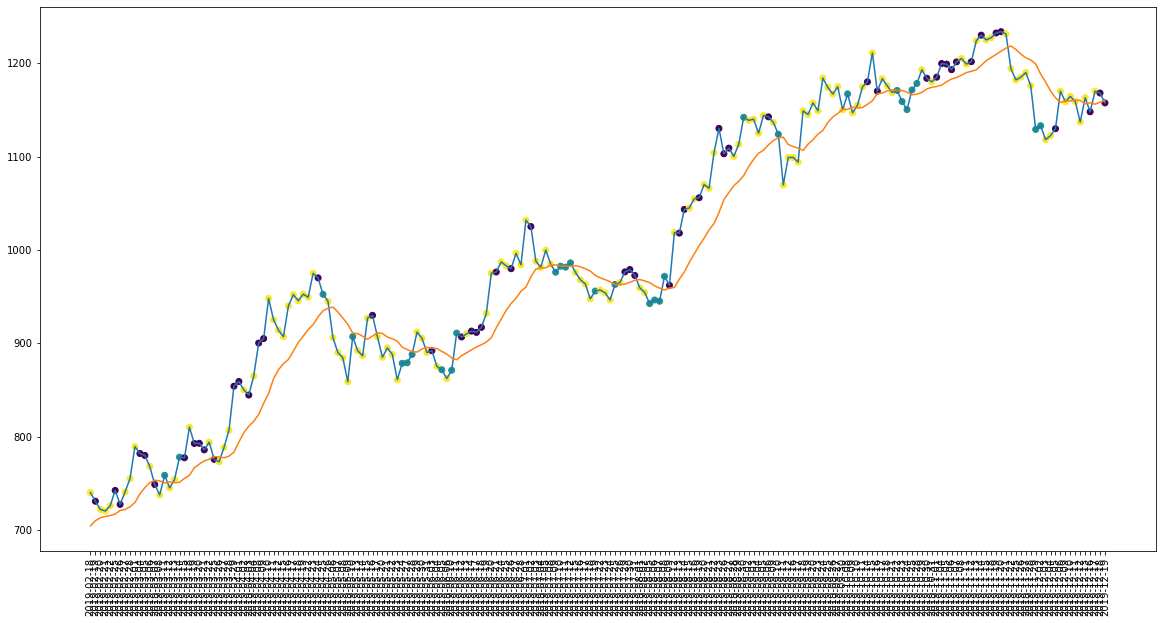

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

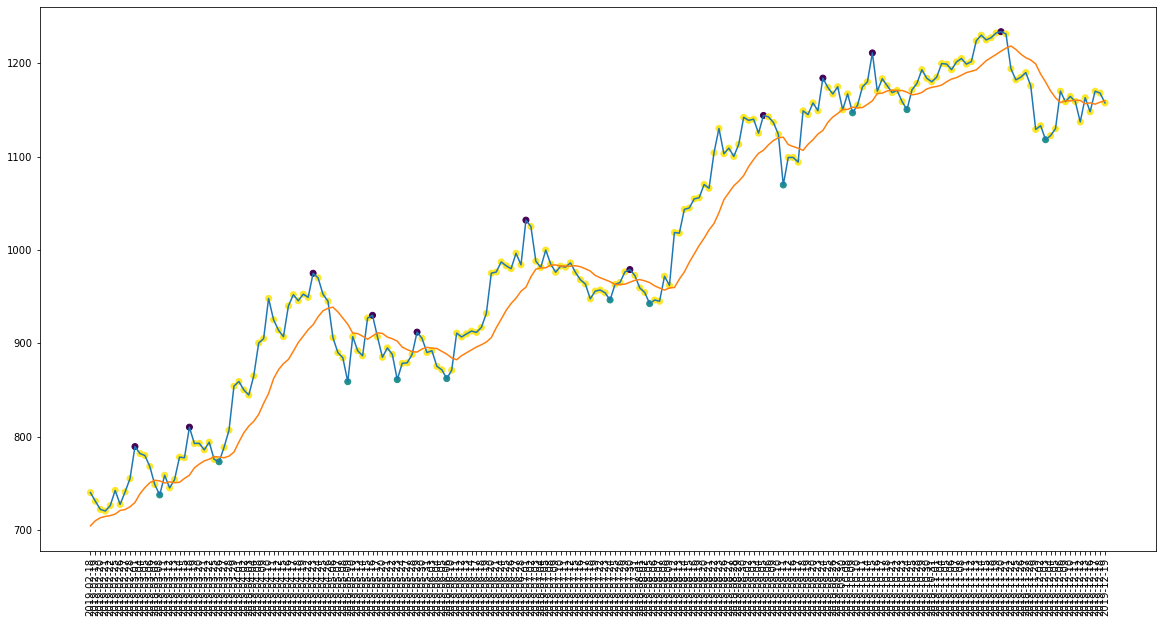

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 28
actual holds but predicted sell: 50
actual predicted holds: 107
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 27.272727272727273%
Percentage holds correct: 57.83783783783784%
actual buys: 11
actual sells: 11
actual holds: 185


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 43.333333333333336%
Percentage sells correct: 49.056603773584904%
Percentage holds correct: 81.30081300813008%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $758.5399780273438
Shares owned at the moment: 13
Cash capital at the moment: $111.86248143005287


Price increase from previously bought: 12.27463060862104%
Share price: $853.989990234375
Shares owned at the moment: 0
Cash capital at the moment: $11183.202212326049


Share price: $952.3699951171876
Shares owned at the moment: 11
Cash capital at the moment: $678.323073684689


Stop Loss Activated!

Share price: $906.0
Shares owned at the moment: 0
Cash capital at the moment: $10616.916573684688


Share price: $907.1199951171876
Shares owned at the moment: 11
Cash capital at the moment: $611.1562475433293


Stop Loss Activated!

Share price: $861.0
Shares owned at the moment: 0
Cash capital at the moment: $10056.110997543328


Share price: $878.5
Shares owned at the moment: 11
Cash capital at the moment: $366.03637254332716


Price increase from previously bought: 10.827834473180387%
Share price: $976.2999877929688
Shares owned at the moment: 0
Cash capital at the moment: $

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   

        correct_holds     correct_low_buys   correct_high_sells  \
0  57.83783783783784%  43.333333333333336%  49.056603773584904%   

    correct_mid_holds        Profit gained  buy_n_hold profit  
0  81.30081300813008%  13.253565030822628%  53.5836826651001%

### Recession

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0


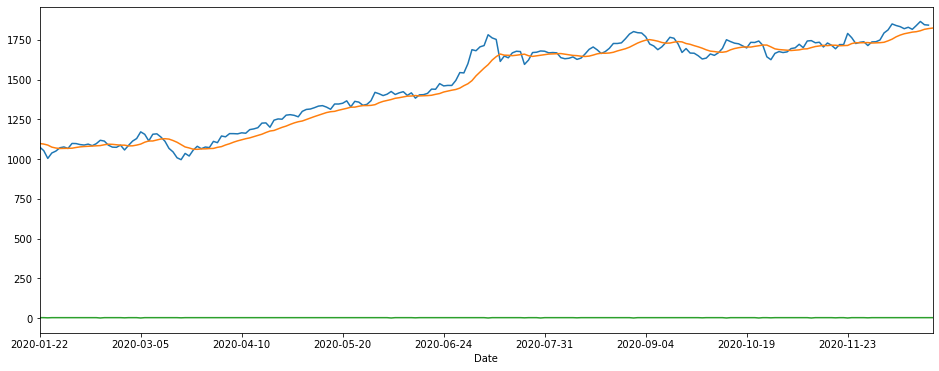

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1510 - accuracy: 0.6587 - mean_squared_error: 2.3758 - weighted_accuracy: 0.6587 - weighted_mean_squared_error: 2.3758
Test loss: 0.15097446739673615
Test accuracy: 0.6586538553237915


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 18, 2: 142, 0: 48})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d       EMA_12   willr_14      OBV_7  labels  \
Date                                                                 
2020-02-19  1096.500000  1082.513705 -22.324305  -423291.0     2.0   
2020-02-20  1118.000000  1084.665443 -12.988283  3281856.0     0.0   
2020-02-21  1112.880005  1089.793836  -4.166667  7962118.0     2.0   
2020-02-24  1087.180054  1093.345554 -10.201830  5068110.0     2.0   
2020-02-25  1074.810059  1092.397016 -40.474836  1203074.0     2.0   

            predictions  actual  
Date                             
2020-02-19            1       2  
2020-02-20            2       0  
2020-02-21            0       2  
2020-02-24            2       2  
2020-02-25            2       2

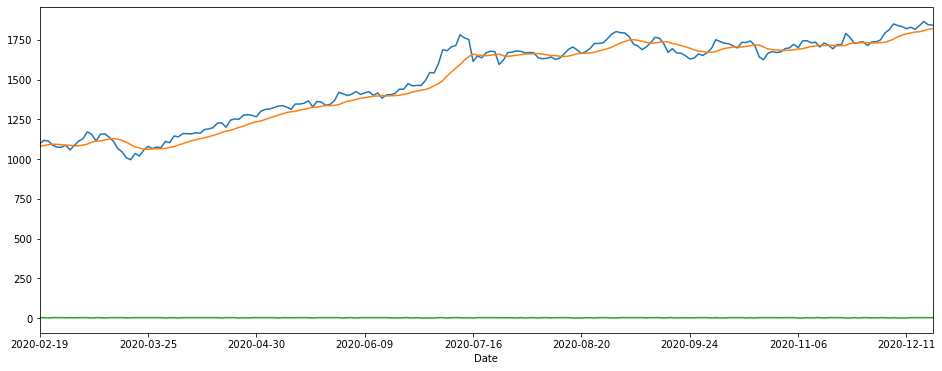

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

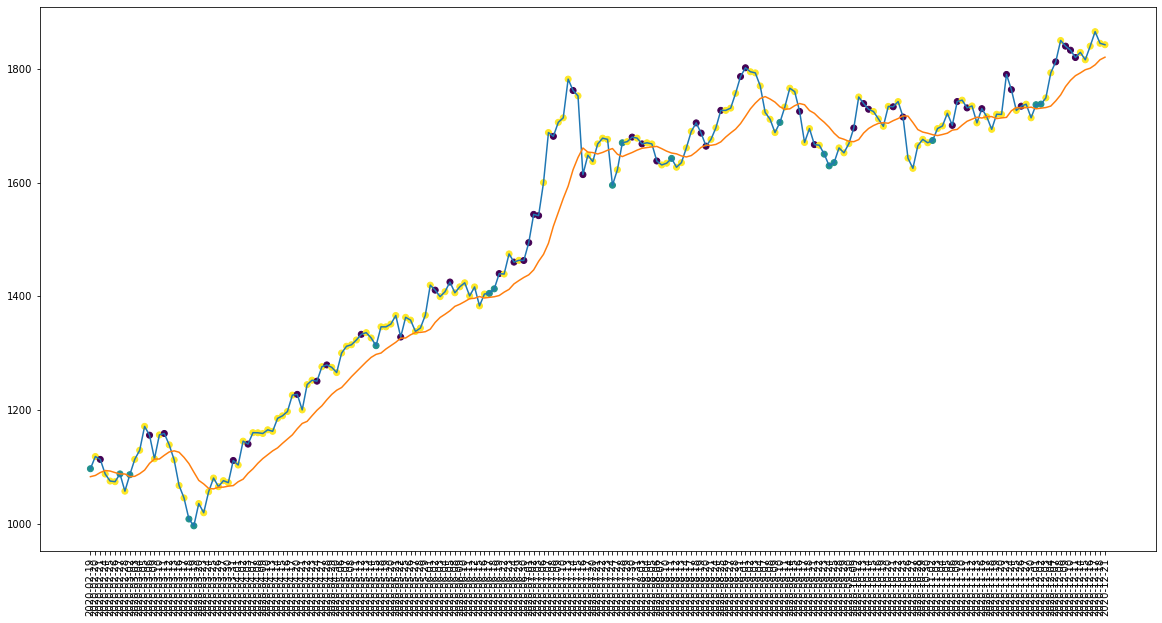

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

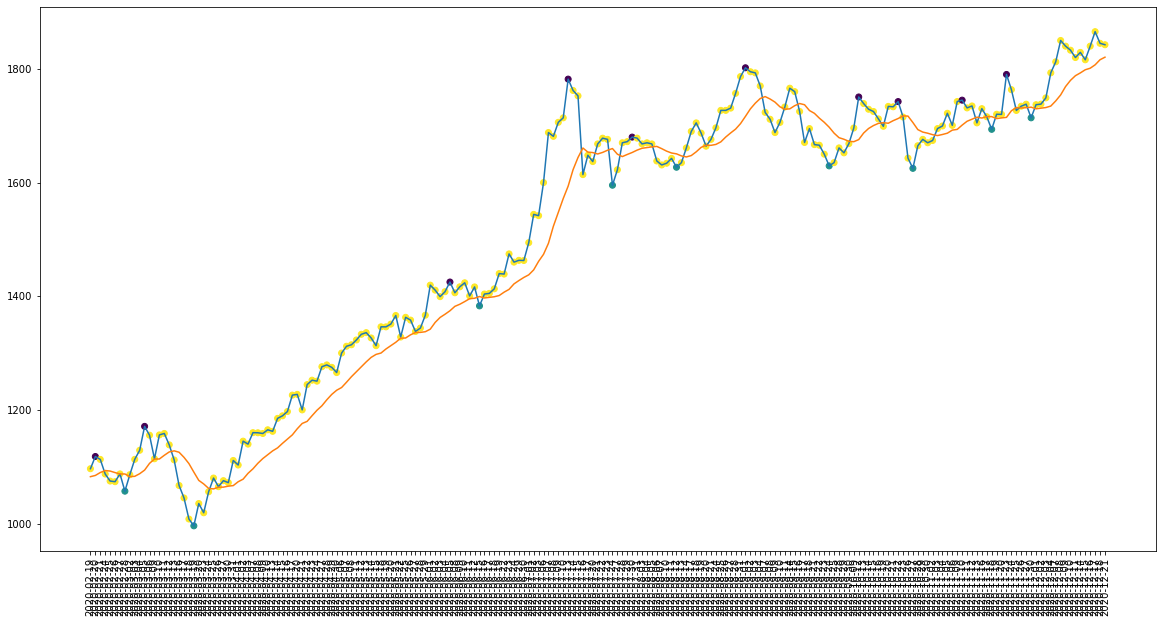

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 15
actual holds but predicted sell: 44
actual predicted holds: 130
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 40.0%
Percentage holds correct: 68.78306878306879%
actual buys: 9
actual sells: 10
actual holds: 189


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 77.77777777777777%
Percentage sells correct: 60.416666666666664%
Percentage holds correct: 85.81560283687944%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1096.5
Shares owned at the moment: 9
Cash capital at the moment: $104.36162499999955


Stop Loss Activated!

Share price: $1057.0
Shares owned at the moment: 0
Cash capital at the moment: $9591.200874999999


Share price: $1086.010009765625
Shares owned at the moment: 8
Cash capital at the moment: $879.2285766601544


Price increase from previously bought: 6.1068571322424825%
Share price: $1155.5
Shares owned at the moment: 0
Cash capital at the moment: $10097.807576660154


Share price: $1007.989990234375
Shares owned at the moment: 9
Cash capital at the moment: $1000.949912292479


Price increase from previously bought: 9.917076521555446%
Share price: $1111.0
Shares owned at the moment: 0
Cash capital at the moment: $10972.452662292479


Share price: $1313.0
Shares owned at the moment: 8
Cash capital at the moment: $439.5666622924782


Price increase from previously bought: 7.147079038926263%
Share price: $1410.7099609375
Shares owned at the moment: 0
Cash capital at th

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   
1       0.658654  33.333333333333336%                40.0%   

        correct_holds     correct_low_buys   correct_high_sells  \
0  57.83783783783784%  43.333333333333336%  49.056603773584904%   
1  68.78306878306879%   77.77777777777777%  60.416666666666664%   

    correct_mid_holds        Profit gained   buy_n_hold profit  
0  81.30081300813008%  13.253565030822628%   53.5836826651001%  
1  85.81560283687944%   55.32266226867672%  66.41259749999998%

### Midea Group

In [71]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


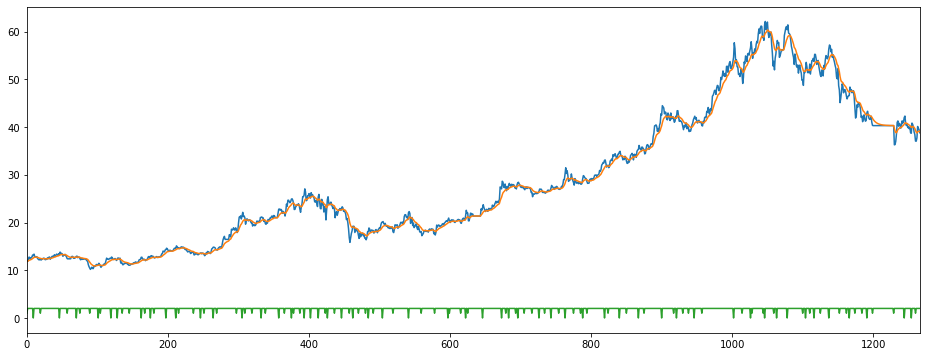

In [72]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [73]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0

In [74]:
# willr_data = []
# price_data = []
# ema_data = []
# #obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# #data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         #data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         #obv_data.append(#data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         #data_15_obv = #data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         #data_15_obv.append([i[3]])
#         count += 1

In [75]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [76]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [77]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [78]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(1253, 64, 64, 1)

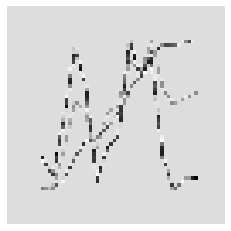

In [79]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [80]:
X = X/255

In [81]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [82]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [83]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [84]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [85]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.9523809523809526, 1: 6.816326530612245, 2: 0.36663007683863885}
Epoch 1/200
8/8 [==============================] - 8s 1s/step - loss: 0.3147 - accuracy: 0.4741 - mse: 2.9001 - weighted_accuracy: 0.3195 - weighted_mse: 2.9863 - val_loss: 0.1806 - val_accuracy: 0.8207 - val_mse: 0.9442 - val_weighted_accuracy: 0.8207 - val_weighted_mse: 0.9442
Epoch 2/200
8/8 [==============================] - 0s 32ms/step - loss: 0.2356 - accuracy: 0.3882 - mse: 1.0427 - weighted_accuracy: 0.3729 - weighted_mse: 1.0974 - val_loss: 0.2120 - val_accuracy: 0.0558 - val_mse: 0.8492 - val_weighted_accuracy: 0.0558 - val_weighted_mse: 0.8492
Epoch 3/200
8/8 [==============================] - 0s 41ms/step - loss: 0.2112 - accuracy: 0.2226 - mse: 1.3428 - weighted_accuracy: 0.3345 - weighted_mse: 1.3611 - val_loss: 0.1997 - val_accuracy: 0.1434 - val_mse: 0.9196 - val_weighted_accuracy: 0.1434 - val_weighted_mse: 0.9196
Epoch 4/200
8/8 [==============================] - 0s 40ms/step - loss: 0.2059 - accur

Epoch 29/200
8/8 [==============================] - 0s 37ms/step - loss: 0.2063 - accuracy: 0.2216 - mse: 1.1791 - weighted_accuracy: 0.3084 - weighted_mse: 1.1521 - val_loss: 0.2116 - val_accuracy: 0.0677 - val_mse: 0.9453 - val_weighted_accuracy: 0.0677 - val_weighted_mse: 0.9453
Epoch 30/200
8/8 [==============================] - 0s 45ms/step - loss: 0.2041 - accuracy: 0.2146 - mse: 1.2255 - weighted_accuracy: 0.2888 - weighted_mse: 1.1975 - val_loss: 0.2145 - val_accuracy: 0.0677 - val_mse: 0.9717 - val_weighted_accuracy: 0.0677 - val_weighted_mse: 0.9717
Epoch 31/200
8/8 [==============================] - 0s 41ms/step - loss: 0.1974 - accuracy: 0.2405 - mse: 1.1071 - weighted_accuracy: 0.4282 - weighted_mse: 1.0462 - val_loss: 0.2120 - val_accuracy: 0.0677 - val_mse: 0.9645 - val_weighted_accuracy: 0.0677 - val_weighted_mse: 0.9645
Epoch 32/200
8/8 [==============================] - 0s 33ms/step - loss: 0.1996 - accuracy: 0.2495 - mse: 1.4127 - weighted_accuracy: 0.3834 - weighted

Epoch 58/200
8/8 [==============================] - 0s 37ms/step - loss: 0.2002 - accuracy: 0.1667 - mse: 1.1616 - weighted_accuracy: 0.3806 - weighted_mse: 1.1067 - val_loss: 0.2098 - val_accuracy: 0.0717 - val_mse: 1.0085 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 1.0085
Epoch 59/200
8/8 [==============================] - 0s 33ms/step - loss: 0.1973 - accuracy: 0.1487 - mse: 1.1890 - weighted_accuracy: 0.3956 - weighted_mse: 1.1821 - val_loss: 0.2148 - val_accuracy: 0.0637 - val_mse: 0.9150 - val_weighted_accuracy: 0.0637 - val_weighted_mse: 0.9150
Epoch 60/200
8/8 [==============================] - 0s 40ms/step - loss: 0.1938 - accuracy: 0.1936 - mse: 1.0951 - weighted_accuracy: 0.4155 - weighted_mse: 1.0787 - val_loss: 0.2092 - val_accuracy: 0.0637 - val_mse: 1.0238 - val_weighted_accuracy: 0.0637 - val_weighted_mse: 1.0238
Epoch 61/200
8/8 [==============================] - 0s 46ms/step - loss: 0.1926 - accuracy: 0.2824 - mse: 1.2811 - weighted_accuracy: 0.3947 - weighted

Epoch 87/200
8/8 [==============================] - 0s 42ms/step - loss: 0.1795 - accuracy: 0.2535 - mse: 1.2638 - weighted_accuracy: 0.5484 - weighted_mse: 1.3262 - val_loss: 0.1991 - val_accuracy: 0.0797 - val_mse: 1.0026 - val_weighted_accuracy: 0.0797 - val_weighted_mse: 1.0026
Epoch 88/200
8/8 [==============================] - 0s 36ms/step - loss: 0.1794 - accuracy: 0.2206 - mse: 1.1703 - weighted_accuracy: 0.5571 - weighted_mse: 1.1938 - val_loss: 0.2087 - val_accuracy: 0.0637 - val_mse: 0.9885 - val_weighted_accuracy: 0.0637 - val_weighted_mse: 0.9885
Epoch 89/200
8/8 [==============================] - 0s 42ms/step - loss: 0.1898 - accuracy: 0.1946 - mse: 1.2044 - weighted_accuracy: 0.4980 - weighted_mse: 1.1948 - val_loss: 0.2042 - val_accuracy: 0.0757 - val_mse: 1.0037 - val_weighted_accuracy: 0.0757 - val_weighted_mse: 1.0037
Epoch 90/200
8/8 [==============================] - 0s 40ms/step - loss: 0.1835 - accuracy: 0.2605 - mse: 1.1907 - weighted_accuracy: 0.5082 - weighted

Epoch 116/200
8/8 [==============================] - 0s 39ms/step - loss: 0.1810 - accuracy: 0.2445 - mse: 1.1931 - weighted_accuracy: 0.5538 - weighted_mse: 1.1919 - val_loss: 0.1724 - val_accuracy: 0.6414 - val_mse: 0.9708 - val_weighted_accuracy: 0.6414 - val_weighted_mse: 0.9708
Epoch 117/200
8/8 [==============================] - 0s 35ms/step - loss: 0.1864 - accuracy: 0.3713 - mse: 1.1813 - weighted_accuracy: 0.4810 - weighted_mse: 1.2810 - val_loss: 0.1953 - val_accuracy: 0.1753 - val_mse: 1.0060 - val_weighted_accuracy: 0.1753 - val_weighted_mse: 1.0060
Epoch 118/200
8/8 [==============================] - 0s 38ms/step - loss: 0.1670 - accuracy: 0.2705 - mse: 1.2241 - weighted_accuracy: 0.5947 - weighted_mse: 1.2622 - val_loss: 0.1905 - val_accuracy: 0.2789 - val_mse: 0.9945 - val_weighted_accuracy: 0.2789 - val_weighted_mse: 0.9945
Epoch 119/200
8/8 [==============================] - 0s 36ms/step - loss: 0.1719 - accuracy: 0.2864 - mse: 1.3239 - weighted_accuracy: 0.5533 - weig

Epoch 145/200
8/8 [==============================] - 0s 31ms/step - loss: 0.1623 - accuracy: 0.2515 - mse: 1.2371 - weighted_accuracy: 0.6211 - weighted_mse: 1.2795 - val_loss: 0.1944 - val_accuracy: 0.2271 - val_mse: 1.0732 - val_weighted_accuracy: 0.2271 - val_weighted_mse: 1.0732
Epoch 146/200
8/8 [==============================] - 0s 41ms/step - loss: 0.1619 - accuracy: 0.2944 - mse: 1.4050 - weighted_accuracy: 0.5884 - weighted_mse: 1.4199 - val_loss: 0.1946 - val_accuracy: 0.2470 - val_mse: 1.0829 - val_weighted_accuracy: 0.2470 - val_weighted_mse: 1.0829
Epoch 147/200
8/8 [==============================] - 0s 41ms/step - loss: 0.1627 - accuracy: 0.3004 - mse: 1.3620 - weighted_accuracy: 0.6065 - weighted_mse: 1.4201 - val_loss: 0.1739 - val_accuracy: 0.4661 - val_mse: 1.1069 - val_weighted_accuracy: 0.4661 - val_weighted_mse: 1.1069
Epoch 148/200
8/8 [==============================] - 0s 29ms/step - loss: 0.1656 - accuracy: 0.4431 - mse: 1.3681 - weighted_accuracy: 0.5846 - weig

Epoch 174/200
8/8 [==============================] - 0s 44ms/step - loss: 0.1493 - accuracy: 0.3972 - mse: 1.4611 - weighted_accuracy: 0.6529 - weighted_mse: 1.5471 - val_loss: 0.1862 - val_accuracy: 0.3506 - val_mse: 1.2593 - val_weighted_accuracy: 0.3506 - val_weighted_mse: 1.2593
Epoch 175/200
8/8 [==============================] - 0s 33ms/step - loss: 0.1528 - accuracy: 0.3892 - mse: 1.5759 - weighted_accuracy: 0.6102 - weighted_mse: 1.6426 - val_loss: 0.1819 - val_accuracy: 0.4263 - val_mse: 1.1916 - val_weighted_accuracy: 0.4263 - val_weighted_mse: 1.1916
Epoch 176/200
8/8 [==============================] - 0s 39ms/step - loss: 0.1453 - accuracy: 0.4102 - mse: 1.4435 - weighted_accuracy: 0.6944 - weighted_mse: 1.5106 - val_loss: 0.1790 - val_accuracy: 0.4622 - val_mse: 1.0711 - val_weighted_accuracy: 0.4622 - val_weighted_mse: 1.0711
Epoch 177/200
8/8 [==============================] - 0s 38ms/step - loss: 0.1500 - accuracy: 0.3583 - mse: 1.3767 - weighted_accuracy: 0.6451 - weig

In [86]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.17848306894302368
Test accuracy: 0.4940239191055298


In [87]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.0613273  -0.41213998 -0.34904927]
 [-0.843297   -0.4935977  -0.28915864]
 [-0.18578082 -0.9436275  -0.44751903]
 [-0.8453782  -0.45277518 -0.28085476]
 [-1.1259978  -0.10691421 -0.55190253]
 [-0.7886795  -0.40421033 -0.27619973]
 [-1.4087869  -0.2789532  -0.53369665]
 [-0.41196057 -0.79028374 -0.34117132]
 [-1.1758325  -0.3115967  -0.43522194]
 [-0.5434533  -0.39034426 -0.24514714]
 [-0.2605148  -1.2681161  -0.5236669 ]
 [-0.84690243 -0.37671083 -0.28694397]
 [-0.16749011 -1.6781373  -0.6564958 ]
 [-0.88964826 -0.38462237 -0.2982664 ]
 [-0.5468861  -0.6549836  -0.30092546]
 [-0.35534254 -1.0890545  -0.4469753 ]
 [-1.6099579  -0.07087096 -0.7582087 ]
 [-0.9471563  -0.43113697 -0.30389506]
 [-1.2902287  -0.42470175 -0.4283108 ]
 [-0.22630244 -0.8087299  -0.490118  ]
 [-1.266484   -0.43741602 -0.4151937 ]
 [-1.425552   -0.09982983 -0.6570462 ]
 [-0.9936794  -0.3919412  -0.3550943 ]
 [-0.26319546 -0.63896924 -0.39905992]
 [-0.08360508 -0.89958894 -0.58669835]
 [-0.83898646 -0.51432353

Counter({2: 120, 0: 66, 1: 65})

In [88]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 228, 1: 13, 0: 10})

In [89]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 251
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 60
actual predicted holds: 111
Percentage buys correct: 53.84615384615385%
Percentage sells correct: 60.0%
Percentage holds correct: 48.68421052631579%
actual buys: 13
actual sells: 10
actual holds: 228


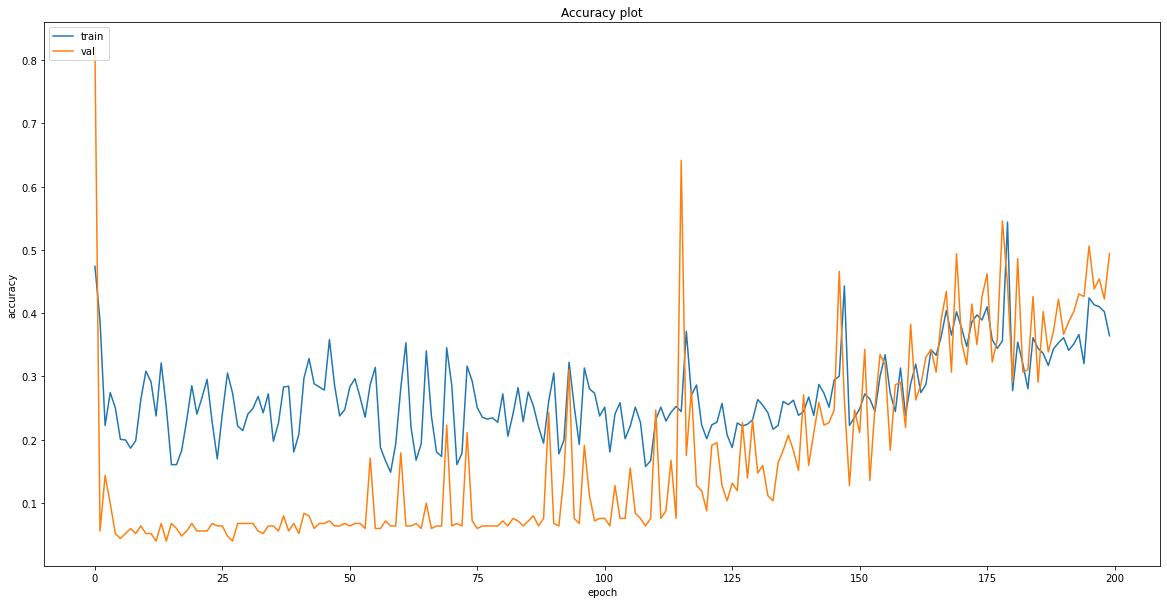

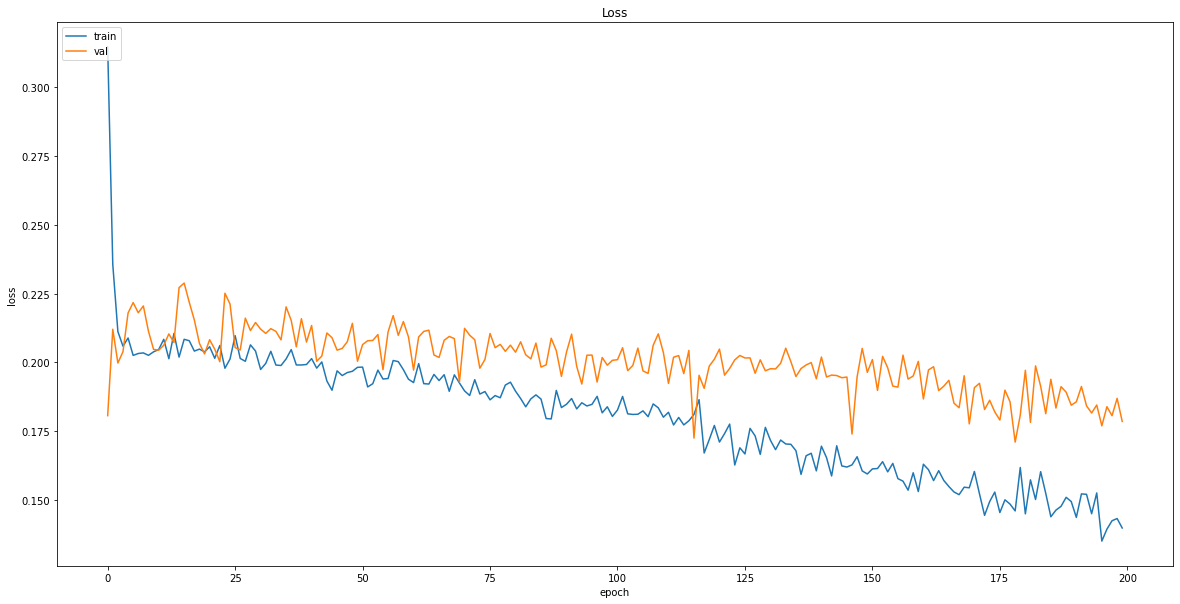

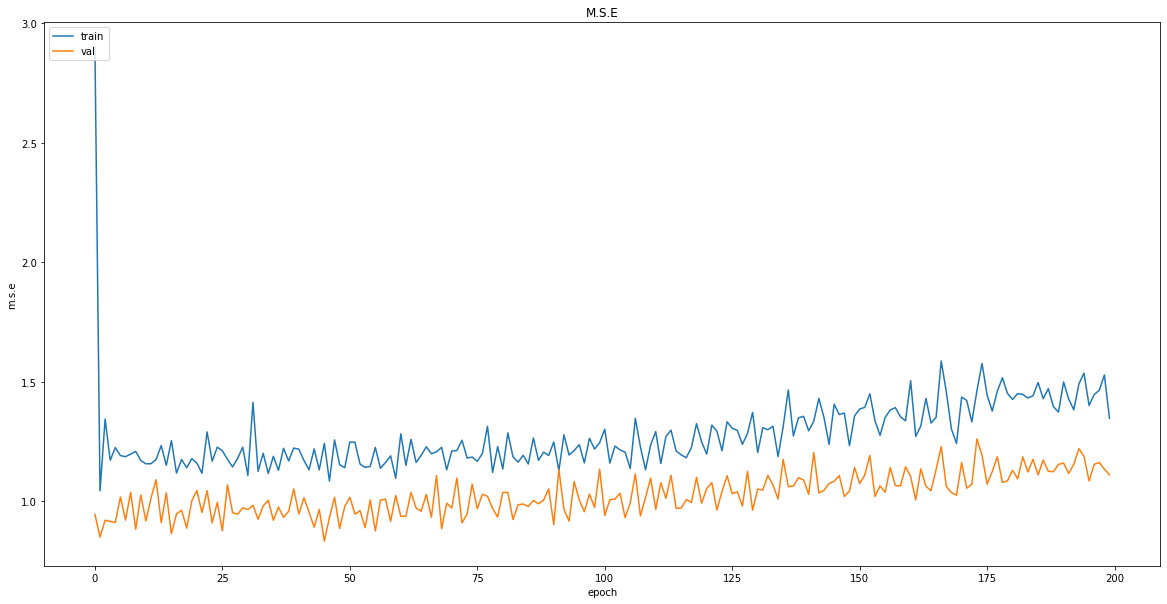

In [90]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [91]:
# Save model
model.save("models/{}".format('midea_image_cnn_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/midea_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

#### Non-Recession

In [92]:
logger = []

In [93]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0


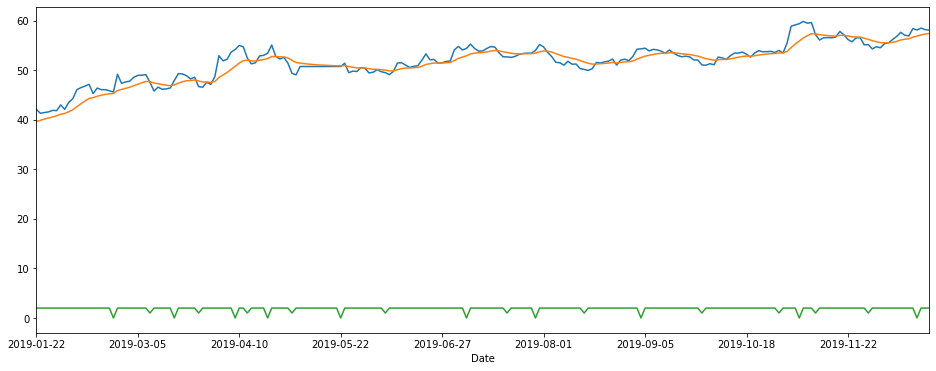

In [94]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

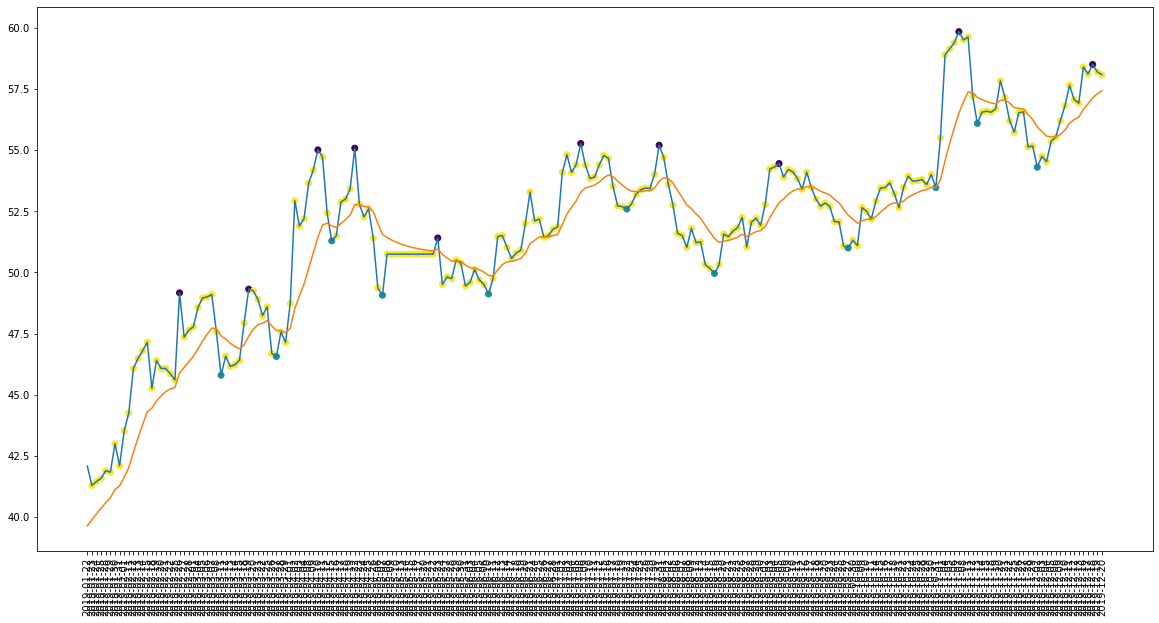

In [95]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [96]:
# willr_data = []
# price_data = []
# ema_data = []
# #obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# #data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         #data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         #obv_data.append(#data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         #data_15_obv = #data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         #data_15_obv.append([i[3]])
#         count += 1
        
# willr_data = np.array(willr_data)
# price_data = np.array(price_data)
# ema_data = np.array(ema_data)
# #obv_data = np.array(#obv_data)

In [97]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [99]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [100]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [101]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1833 - accuracy: 0.4251 - mean_squared_error: 1.1251 - weighted_accuracy: 0.4251 - weighted_mean_squared_error: 1.1251
Test loss: 0.1832706779241562
Test accuracy: 0.4251207709312439


In [102]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 64, 2: 85, 0: 58})

In [103]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [104]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)

In [105]:
# df['previous_1d'] = df['previous_1d'].shift(-1)
# df.dropna(inplace=True)
# df = df.iloc[13:]
# df['predictions'] = predictions
# df['actual'] = actual
# df.head()

In [106]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14        OBV_7  labels  \
Date                                                                 
2019-02-18    46.400002  44.456141 -30.862341  419918481.0     2.0   
2019-02-19    46.080002  44.755197 -13.767016  452488699.0     2.0   
2019-02-20    46.080002  44.959013 -18.975880  424412835.0     2.0   
2019-02-21    45.860001  45.131473 -18.975880  424412835.0     2.0   
2019-02-22    45.610001  45.243554 -26.174460  382970560.0     2.0   

            predictions  actual  
Date                             
2019-02-18            1       2  
2019-02-19            1       2  
2019-02-20            1       2  
2019-02-21            1       2  
2019-02-22            2       2

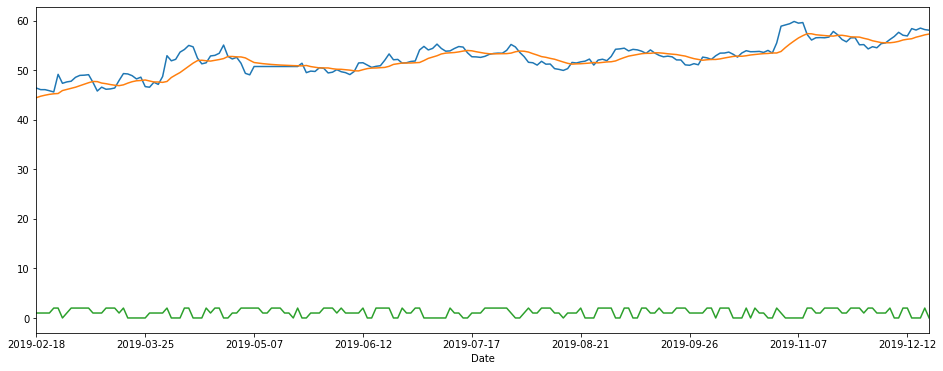

In [107]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

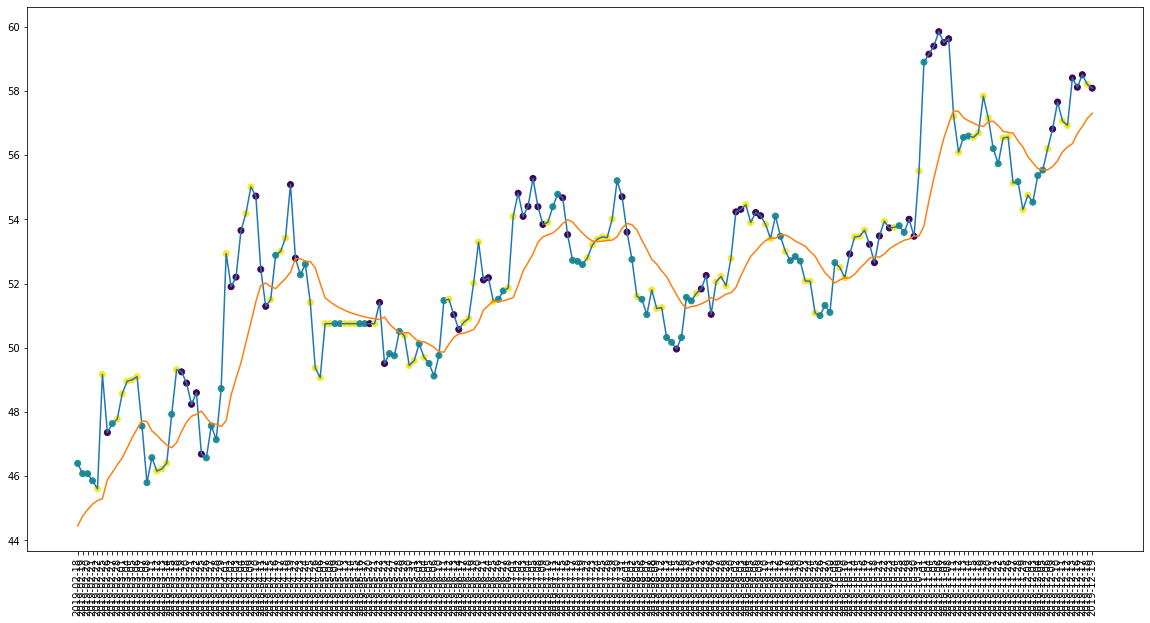

In [108]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

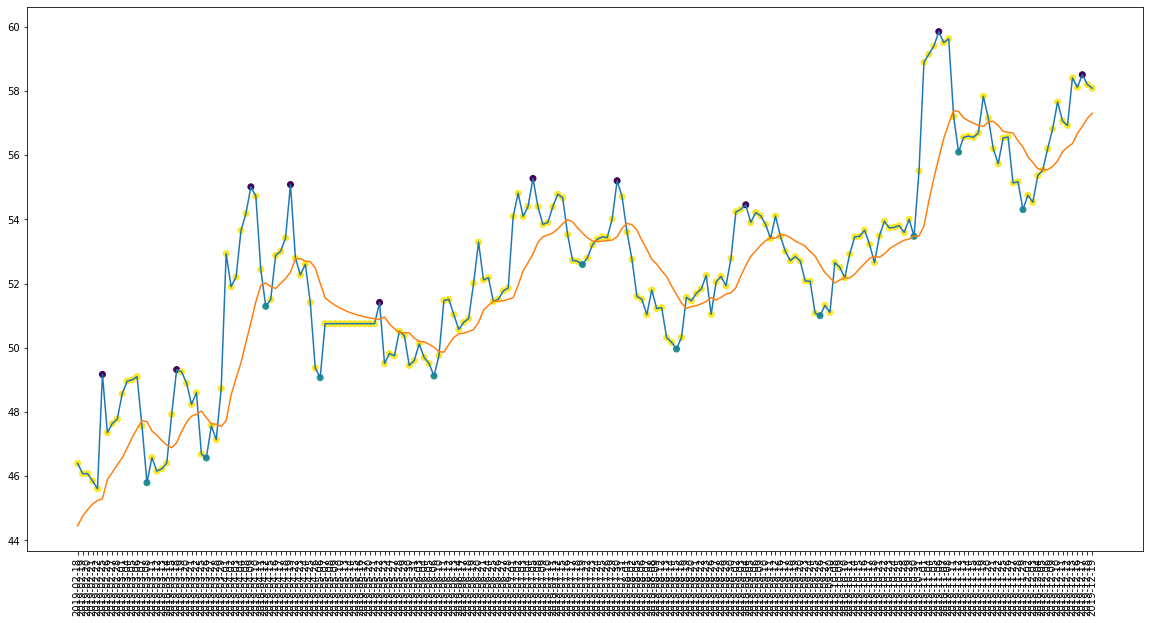

In [109]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [110]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 207
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 58
actual holds but predicted sell: 50
actual predicted holds: 78
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 50.0%
Percentage holds correct: 41.935483870967744%
actual buys: 11
actual sells: 10
actual holds: 186


In [111]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 59.375%
Percentage sells correct: 56.14035087719298%
Percentage holds correct: 78.82352941176471%


In [112]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $46.4000015258789
Shares owned at the moment: 214
Cash capital at the moment: $43.0932725639359


Price increase from previously bought: 5.851147233895548%
Share price: $49.25
Shares owned at the moment: 0
Cash capital at the moment: $10553.609647563935


Share price: $46.56999969482422
Shares owned at the moment: 225
Cash capital at the moment: $46.54452891731307


Price increase from previously bought: 11.139506717237225%
Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $11691.931746295928


Share price: $52.88000106811523
Shares owned at the moment: 220
Cash capital at the moment: $26.33911066436849


Stop Loss Activated!

Share price: $51.40999984741211
Shares owned at the moment: 0
Cash capital at the moment: $11305.436027187348


Share price: $50.75
Shares owned at the moment: 222
Cash capital at the moment: $7.953152187348678


Stop Loss Activated!

Share price: $49.11999893188477
Shares owned at the moment: 0
Cash capital at 

In [113]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


In [114]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   
1       0.658654  33.333333333333336%                40.0%   
2       0.425121   45.45454545454545%                50.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0   57.83783783783784%  43.333333333333336%  49.056603773584904%   
1   68.78306878306879%   77.77777777777777%  60.416666666666664%   
2  41.935483870967744%              59.375%   56.14035087719298%   

    correct_mid_holds        Profit gained    buy_n_hold profit  
0  81.30081300813008%  13.253565030822628%    53.5836826651001%  
1  85.81560283687944%   55.32266226867672%   66.41259749999998%  
2  78.82352941176471%   31.17646658102025%  24.380335833320625%

#### Recession

In [115]:
logger = []

In [116]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0


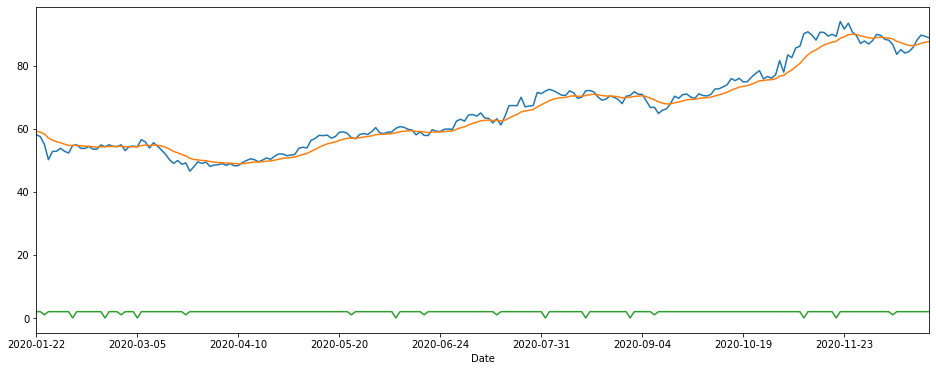

In [117]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

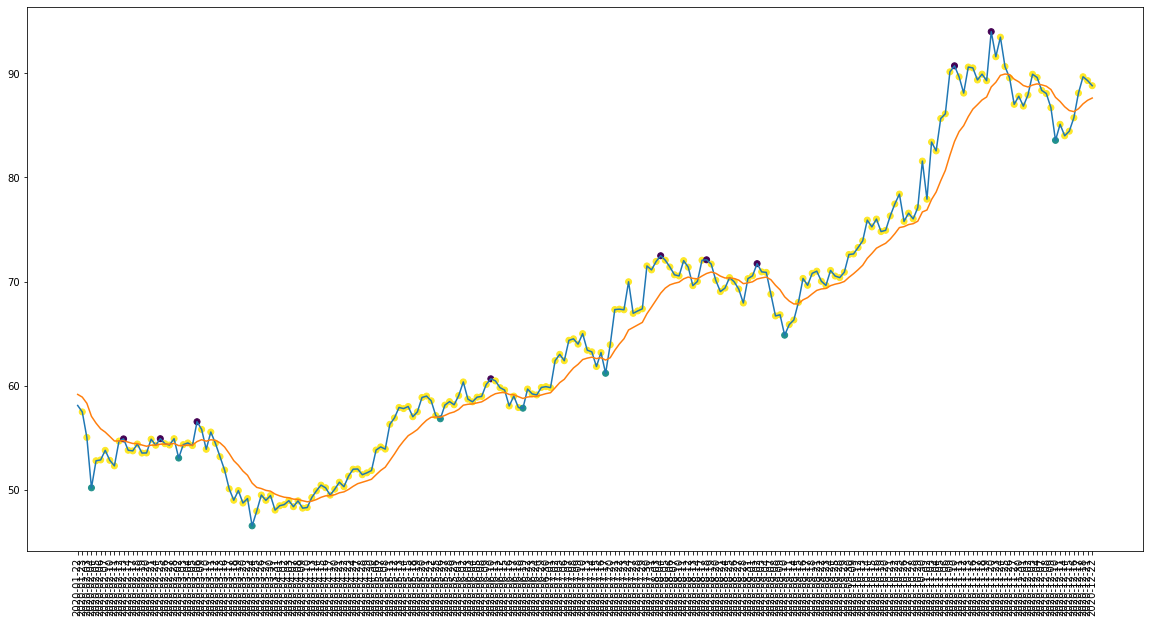

In [118]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['labels'].shift(1).values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [119]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [121]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [122]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [123]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.4279 - mean_squared_error: 1.1325 - weighted_accuracy: 0.4279 - weighted_mean_squared_error: 1.1325
Test loss: 0.18331575393676758
Test accuracy: 0.42788460850715637


In [124]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 92, 0: 65, 1: 51})

In [125]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [126]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df.set_index('Date', inplace=True)

In [127]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2020-02-19    53.540001  54.301035 -52.927131 -33290149.0     2.0   
2020-02-20    54.860001  54.183953 -44.755246  -9557295.0     2.0   
2020-02-21    54.279999  54.287960  -8.665511  27483857.0     2.0   
2020-02-24    54.910000  54.286736 -21.343904  -2296012.0     0.0   
2020-02-25    54.430000  54.382622 -12.602723  38486402.0     2.0   

            predictions  actual  
Date                             
2020-02-19            2       2  
2020-02-20            2       2  
2020-02-21            0       2  
2020-02-24            0       0  
2020-02-25            0       2

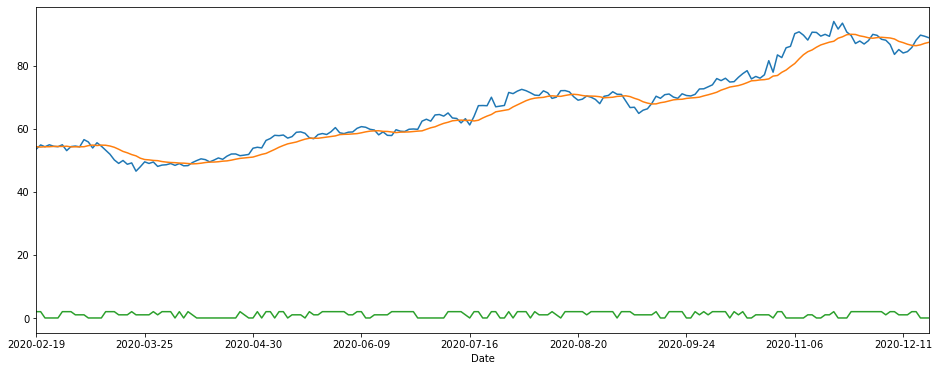

In [128]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

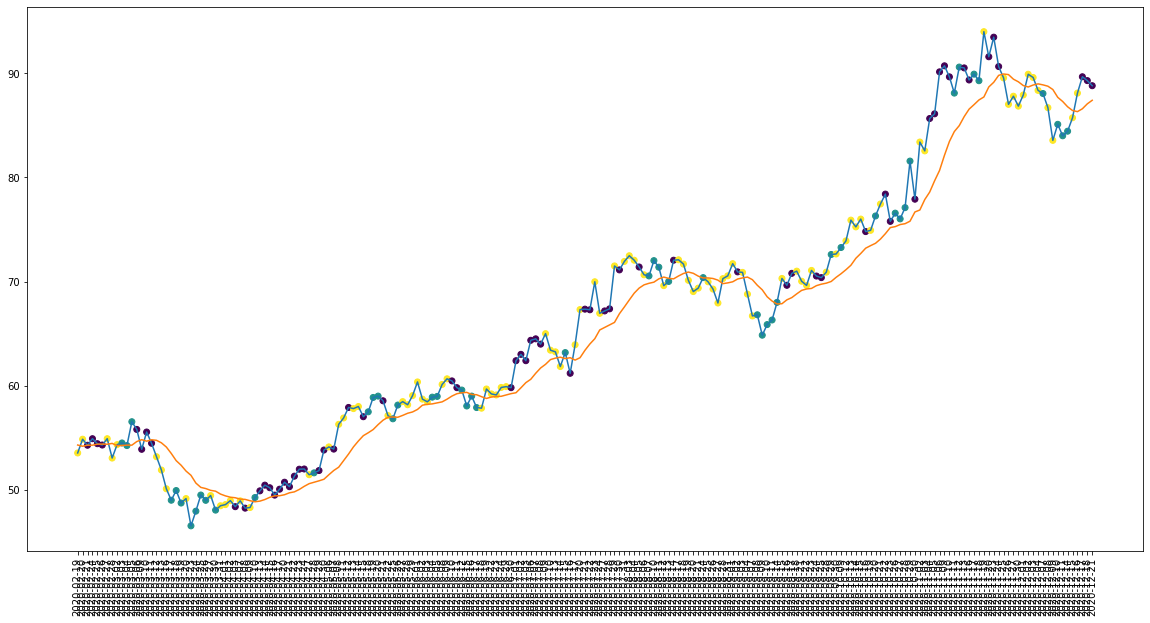

In [129]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

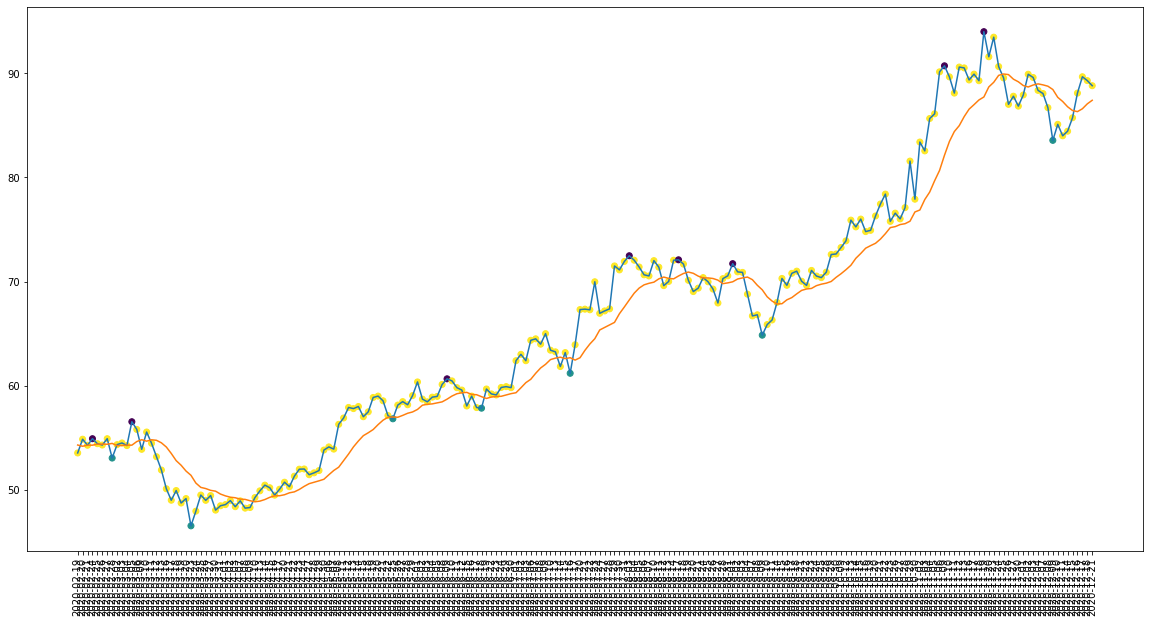

In [130]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [131]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 208
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 47
actual holds but predicted sell: 62
actual predicted holds: 84
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 25.0%
Percentage holds correct: 43.523316062176164%
actual buys: 7
actual sells: 8
actual holds: 193


In [132]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 60.0%
Percentage sells correct: 52.30769230769231%
Percentage holds correct: 80.43478260869566%


In [133]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.5
Shares owned at the moment: 182
Cash capital at the moment: $53.722749999998996


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9473.547076946255


Share price: $49.0
Shares owned at the moment: 192
Cash capital at the moment: $39.67507694625601


Stop Loss Activated!

Share price: $46.540000915527344
Shares owned at the moment: 0
Cash capital at the moment: $8950.782132244107


Share price: $46.540000915527344
Shares owned at the moment: 191
Cash capital at the moment: $37.19682189750347


Price increase from previously bought: 6.925551947987829%
Share price: $49.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9541.887137538904


Share price: $51.63000106811523
Shares owned at the moment: 184
Cash capital at the moment: $15.842160465235793


Price increase from previously bought: 11.855864606647092%
Share price: $57.90999984741211
Shares owned at the moment: 0
Cash capital at 

In [134]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


In [135]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   
1       0.658654  33.333333333333336%                40.0%   
2       0.425121   45.45454545454545%                50.0%   
3       0.427885  42.857142857142854%                25.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0   57.83783783783784%  43.333333333333336%  49.056603773584904%   
1   68.78306878306879%   77.77777777777777%  60.416666666666664%   
2  41.935483870967744%              59.375%   56.14035087719298%   
3  43.523316062176164%                60.0%   52.30769230769231%   

    correct_mid_holds        Profit gained    buy_n_hold profit  
0  81.30081300813008%  13.253565030822628%    53.5836826651001%  
1  85.81560283687944%   55.32266226867672%   66.41259749999998%  
2  78.82352941176471%   31.17646658102025%  24.380335833320625%  
3  80.43478260869566%  36.132353349885854%   64.87407351390837%

## Walmart

In [136]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


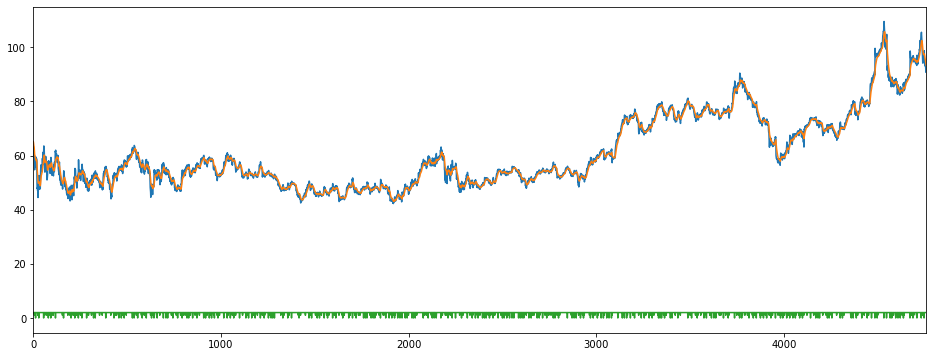

In [137]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [138]:
df.set_index('Date', inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0

In [139]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [140]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [142]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

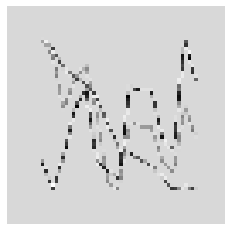

In [143]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [144]:
X = X/255

In [145]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [146]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [147]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [148]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [149]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.148775894538606, 1: 7.3565891472868215, 2: 0.3670824871869258}
Epoch 1/200
30/30 [==============================] - 3s 84ms/step - loss: 0.2465 - accuracy: 0.3812 - mse: 1.5936 - weighted_accuracy: 0.3171 - weighted_mse: 1.7095 - val_loss: 0.1947 - val_accuracy: 0.0474 - val_mse: 0.9028 - val_weighted_accuracy: 0.0474 - val_weighted_mse: 0.9028
Epoch 2/200
30/30 [==============================] - 0s 13ms/step - loss: 0.2075 - accuracy: 0.3037 - mse: 1.1995 - weighted_accuracy: 0.3375 - weighted_mse: 1.2157 - val_loss: 0.2026 - val_accuracy: 0.2687 - val_mse: 0.8212 - val_weighted_accuracy: 0.2687 - val_weighted_mse: 0.8212
Epoch 3/200
30/30 [==============================] - 0s 14ms/step - loss: 0.2030 - accuracy: 0.3620 - mse: 1.1624 - weighted_accuracy: 0.3493 - weighted_mse: 1.1685 - val_loss: 0.2084 - val_accuracy: 0.0464 - val_mse: 0.8850 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.8850
Epoch 4/200
30/30 [==============================] - 0s 13ms/step - loss: 0.204

30/30 [==============================] - 1s 17ms/step - loss: 0.1966 - accuracy: 0.2287 - mse: 1.1779 - weighted_accuracy: 0.3977 - weighted_mse: 1.1628 - val_loss: 0.1958 - val_accuracy: 0.0854 - val_mse: 1.0111 - val_weighted_accuracy: 0.0854 - val_weighted_mse: 1.0111
Epoch 29/200
30/30 [==============================] - 0s 16ms/step - loss: 0.1941 - accuracy: 0.2816 - mse: 1.2244 - weighted_accuracy: 0.4097 - weighted_mse: 1.2165 - val_loss: 0.1981 - val_accuracy: 0.0717 - val_mse: 0.9770 - val_weighted_accuracy: 0.0717 - val_weighted_mse: 0.9770
Epoch 30/200
30/30 [==============================] - 1s 17ms/step - loss: 0.1947 - accuracy: 0.2756 - mse: 1.1912 - weighted_accuracy: 0.4402 - weighted_mse: 1.1835 - val_loss: 0.1926 - val_accuracy: 0.1328 - val_mse: 1.0740 - val_weighted_accuracy: 0.1328 - val_weighted_mse: 1.0740
Epoch 31/200
30/30 [==============================] - 0s 14ms/step - loss: 0.1937 - accuracy: 0.3372 - mse: 1.2108 - weighted_accuracy: 0.4000 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1772 - accuracy: 0.2136 - mse: 1.3359 - weighted_accuracy: 0.5271 - weighted_mse: 1.2617 - val_loss: 0.1983 - val_accuracy: 0.0843 - val_mse: 1.1559 - val_weighted_accuracy: 0.0843 - val_weighted_mse: 1.1559
Epoch 58/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1728 - accuracy: 0.2250 - mse: 1.3807 - weighted_accuracy: 0.5473 - weighted_mse: 1.3268 - val_loss: 0.1932 - val_accuracy: 0.1401 - val_mse: 1.0794 - val_weighted_accuracy: 0.1401 - val_weighted_mse: 1.0794
Epoch 59/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1737 - accuracy: 0.2081 - mse: 1.3309 - weighted_accuracy: 0.5390 - weighted_mse: 1.2789 - val_loss: 0.1913 - val_accuracy: 0.1517 - val_mse: 1.1923 - val_weighted_accuracy: 0.1517 - val_weighted_mse: 1.1923
Epoch 60/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1717 - accuracy: 0.2266 - mse: 1.3918 - weighted_accuracy: 0.5537 - 

30/30 [==============================] - 1s 30ms/step - loss: 0.1595 - accuracy: 0.2489 - mse: 1.5015 - weighted_accuracy: 0.6072 - weighted_mse: 1.4511 - val_loss: 0.1906 - val_accuracy: 0.2055 - val_mse: 1.2122 - val_weighted_accuracy: 0.2055 - val_weighted_mse: 1.2122
Epoch 86/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1618 - accuracy: 0.2150 - mse: 1.4855 - weighted_accuracy: 0.5732 - weighted_mse: 1.4106 - val_loss: 0.1901 - val_accuracy: 0.1865 - val_mse: 1.3109 - val_weighted_accuracy: 0.1865 - val_weighted_mse: 1.3109
Epoch 87/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1597 - accuracy: 0.2397 - mse: 1.4968 - weighted_accuracy: 0.5964 - weighted_mse: 1.4437 - val_loss: 0.1893 - val_accuracy: 0.2276 - val_mse: 1.2488 - val_weighted_accuracy: 0.2276 - val_weighted_mse: 1.2488
Epoch 88/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1574 - accuracy: 0.2292 - mse: 1.4893 - weighted_accuracy: 0.6160 - weighted_mse:

30/30 [==============================] - 1s 34ms/step - loss: 0.1444 - accuracy: 0.2956 - mse: 1.6506 - weighted_accuracy: 0.6731 - weighted_mse: 1.6566 - val_loss: 0.1910 - val_accuracy: 0.2561 - val_mse: 1.5039 - val_weighted_accuracy: 0.2561 - val_weighted_mse: 1.5039
Epoch 114/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1448 - accuracy: 0.3201 - mse: 1.6292 - weighted_accuracy: 0.6606 - weighted_mse: 1.6304 - val_loss: 0.1897 - val_accuracy: 0.2740 - val_mse: 1.5423 - val_weighted_accuracy: 0.2740 - val_weighted_mse: 1.5423
Epoch 115/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1437 - accuracy: 0.3203 - mse: 1.7088 - weighted_accuracy: 0.6676 - weighted_mse: 1.7365 - val_loss: 0.1884 - val_accuracy: 0.2803 - val_mse: 1.4996 - val_weighted_accuracy: 0.2803 - val_weighted_mse: 1.4996
Epoch 116/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1411 - accuracy: 0.3138 - mse: 1.7147 - weighted_accuracy: 0.6690 - weighted_m

Epoch 142/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1305 - accuracy: 0.4191 - mse: 1.9049 - weighted_accuracy: 0.7169 - weighted_mse: 2.0538 - val_loss: 0.1714 - val_accuracy: 0.5026 - val_mse: 1.6595 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 1.6595
Epoch 143/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1297 - accuracy: 0.4494 - mse: 1.9111 - weighted_accuracy: 0.7404 - weighted_mse: 2.0569 - val_loss: 0.1613 - val_accuracy: 0.5890 - val_mse: 1.6478 - val_weighted_accuracy: 0.5890 - val_weighted_mse: 1.6478
Epoch 144/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1309 - accuracy: 0.4434 - mse: 1.9374 - weighted_accuracy: 0.7186 - weighted_mse: 2.0784 - val_loss: 0.1803 - val_accuracy: 0.4089 - val_mse: 1.7125 - val_weighted_accuracy: 0.4089 - val_weighted_mse: 1.7125
Epoch 145/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1279 - accuracy: 0.4402 - mse: 1.9460 - weighted_accuracy: 0.715

Epoch 171/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1112 - accuracy: 0.5566 - mse: 2.2549 - weighted_accuracy: 0.7817 - weighted_mse: 2.6988 - val_loss: 0.1546 - val_accuracy: 0.6228 - val_mse: 1.7828 - val_weighted_accuracy: 0.6228 - val_weighted_mse: 1.7828
Epoch 172/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1137 - accuracy: 0.5561 - mse: 2.2559 - weighted_accuracy: 0.7852 - weighted_mse: 2.6764 - val_loss: 0.1565 - val_accuracy: 0.6185 - val_mse: 1.9279 - val_weighted_accuracy: 0.6185 - val_weighted_mse: 1.9279
Epoch 173/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1146 - accuracy: 0.5598 - mse: 2.2780 - weighted_accuracy: 0.7665 - weighted_mse: 2.6859 - val_loss: 0.1509 - val_accuracy: 0.6470 - val_mse: 1.7695 - val_weighted_accuracy: 0.6470 - val_weighted_mse: 1.7695
Epoch 174/200
30/30 [==============================] - 1s 29ms/step - loss: 0.1114 - accuracy: 0.5954 - mse: 2.2335 - weighted_accuracy: 0.788

30/30 [==============================] - 1s 26ms/step - loss: 0.0979 - accuracy: 0.6209 - mse: 2.6373 - weighted_accuracy: 0.8232 - weighted_mse: 3.4135 - val_loss: 0.1344 - val_accuracy: 0.7123 - val_mse: 2.1322 - val_weighted_accuracy: 0.7123 - val_weighted_mse: 2.1322
Epoch 200/200
30/30 [==============================] - 1s 25ms/step - loss: 0.0990 - accuracy: 0.6386 - mse: 2.6871 - weighted_accuracy: 0.8224 - weighted_mse: 3.2713 - val_loss: 0.1306 - val_accuracy: 0.7387 - val_mse: 1.9968 - val_weighted_accuracy: 0.7387 - val_weighted_mse: 1.9968


In [150]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.13057121634483337
Test accuracy: 0.7386723160743713


In [151]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.403048   -0.9140384  -0.04123646]
 [-0.69291806 -1.4006168  -0.3937523 ]
 [-0.7607295  -2.1629636  -0.06876688]
 ...
 [-1.5223771  -0.9643164  -0.01700404]
 [-0.6391923  -1.557449   -0.18412733]
 [-0.842776   -1.7678264  -0.02068205]]


Counter({2: 740, 1: 131, 0: 78})

In [152]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 44, 1: 43})

In [153]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 15
actual buys but predicted sell: 1
actual buys but predicted hold: 27
actual sells but predicted buy: 3
actual predicted sells: 7
actual sells but predicted hold: 34
actual holds but predicted buy: 113
actual holds but predicted sell: 70
actual predicted holds: 679
Percentage buys correct: 34.883720930232556%
Percentage sells correct: 15.909090909090908%
Percentage holds correct: 78.77030162412993%
actual buys: 43
actual sells: 44
actual holds: 862


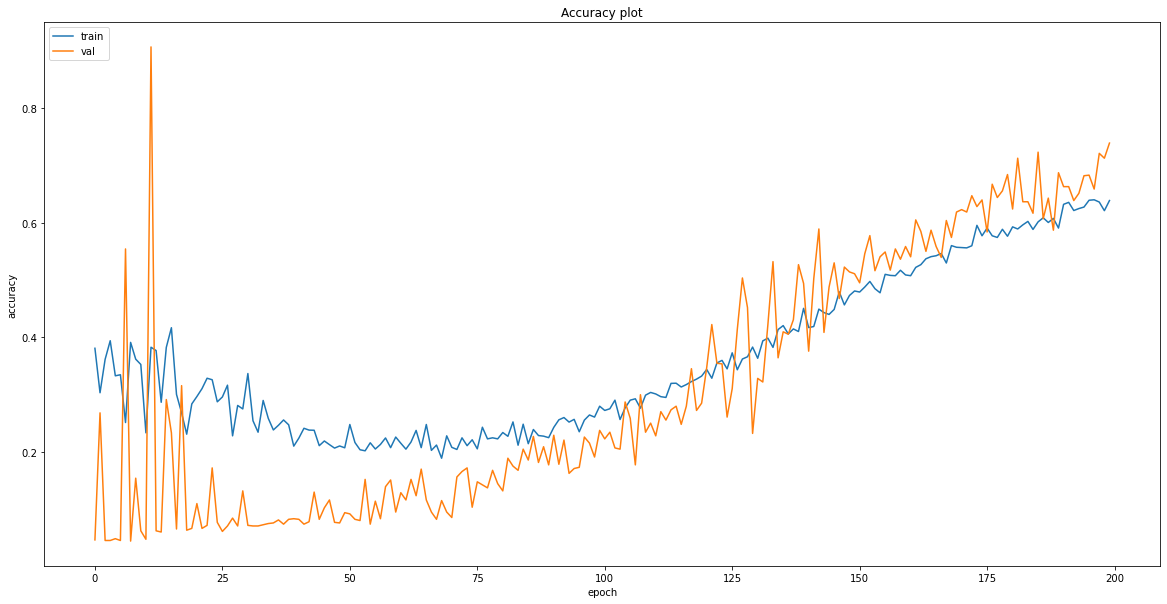

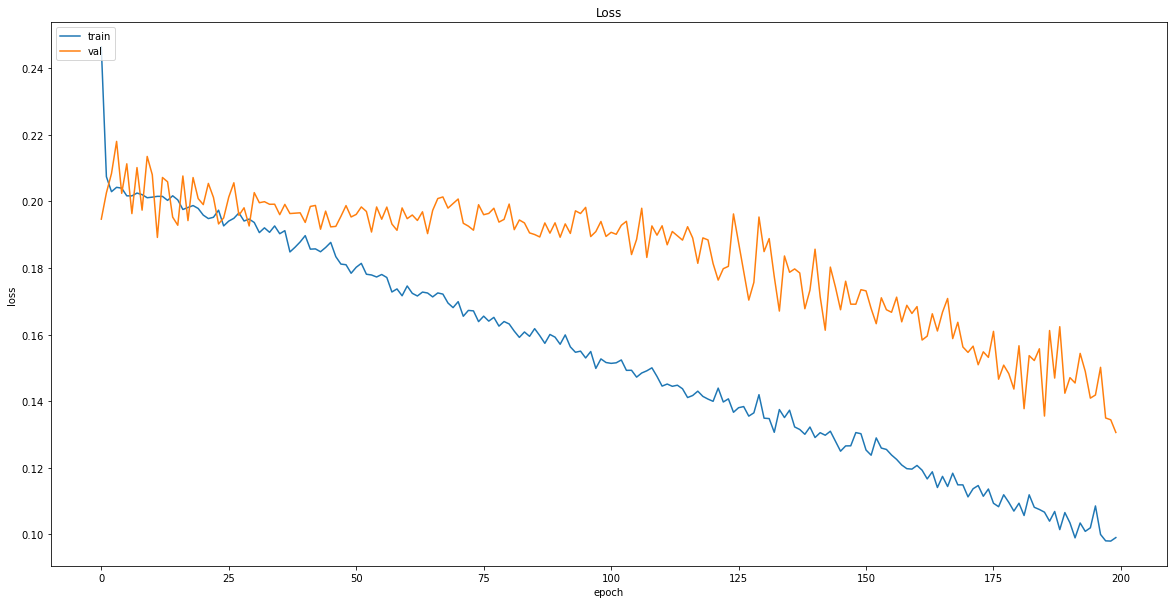

In [154]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [155]:
# Save model
model.save("models/{}".format('walmart_image_cnn_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/walmart_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

#### Non-Recession

In [156]:
logger = []

In [157]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    97.730003  95.334462  -7.164539  58918700.0     2.0
2019-01-23    97.489998  95.666083 -13.843922  50855500.0     0.0
2019-01-24    98.709999  96.134378  -9.609606  59201300.0     2.0
2019-01-25    98.360001  96.476781 -14.864842  51591600.0     2.0
2019-01-28    96.940002  96.548046 -38.683751  44373400.0     2.0


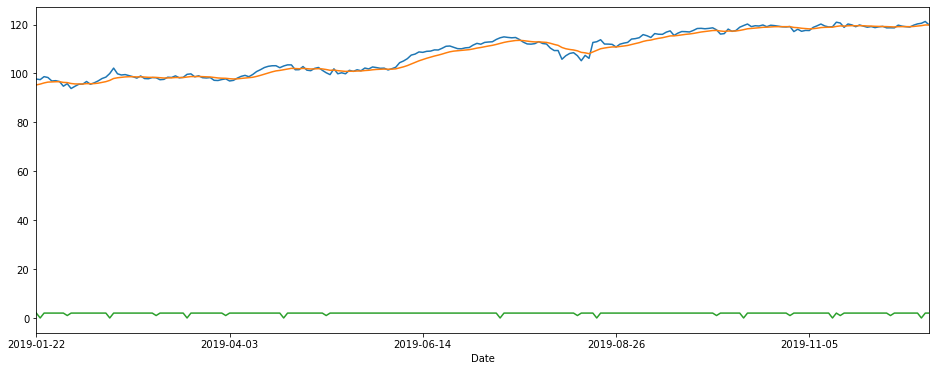

In [158]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [159]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [160]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [161]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [162]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [163]:
model = tf.keras.models.load_model("models/walmart_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 11ms/step - loss: 0.1284 - accuracy: 0.7294 - mean_squared_error: 2.0111 - weighted_accuracy: 0.7294 - weighted_mean_squared_error: 2.0111
Test loss: 0.128372460603714
Test accuracy: 0.7293577790260315


In [164]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 0: 20, 1: 29})

In [165]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [166]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)

In [167]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14       OBV_7  labels  \
Date                                                                
2019-02-11    96.199997  95.814812 -60.416634  53751900.0     2.0   
2019-02-12    96.970001  95.874072 -50.480811  59294700.0     2.0   
2019-02-13    97.940002  96.042676 -33.448300  65176000.0     2.0   
2019-02-14    98.519997  96.334572 -16.724150  70634500.0     2.0   
2019-02-15    99.989998  96.670792 -11.165857  77835300.0     2.0   

            predictions  actual  
Date                             
2019-02-11            2       2  
2019-02-12            0       2  
2019-02-13            2       2  
2019-02-14            2       2  
2019-02-15            2       2

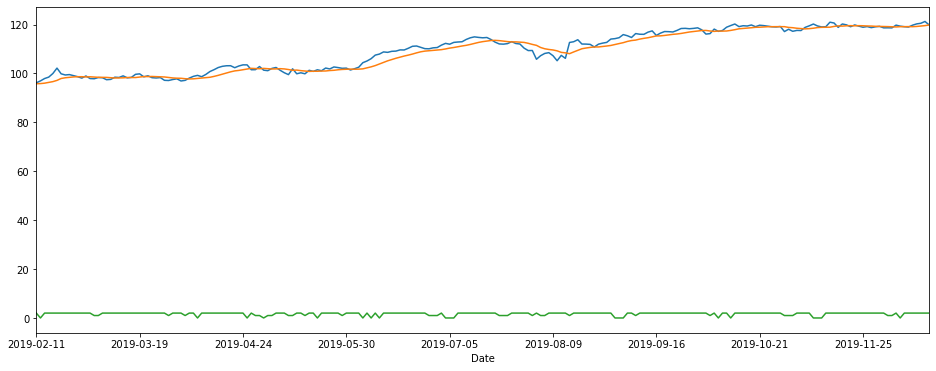

In [168]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

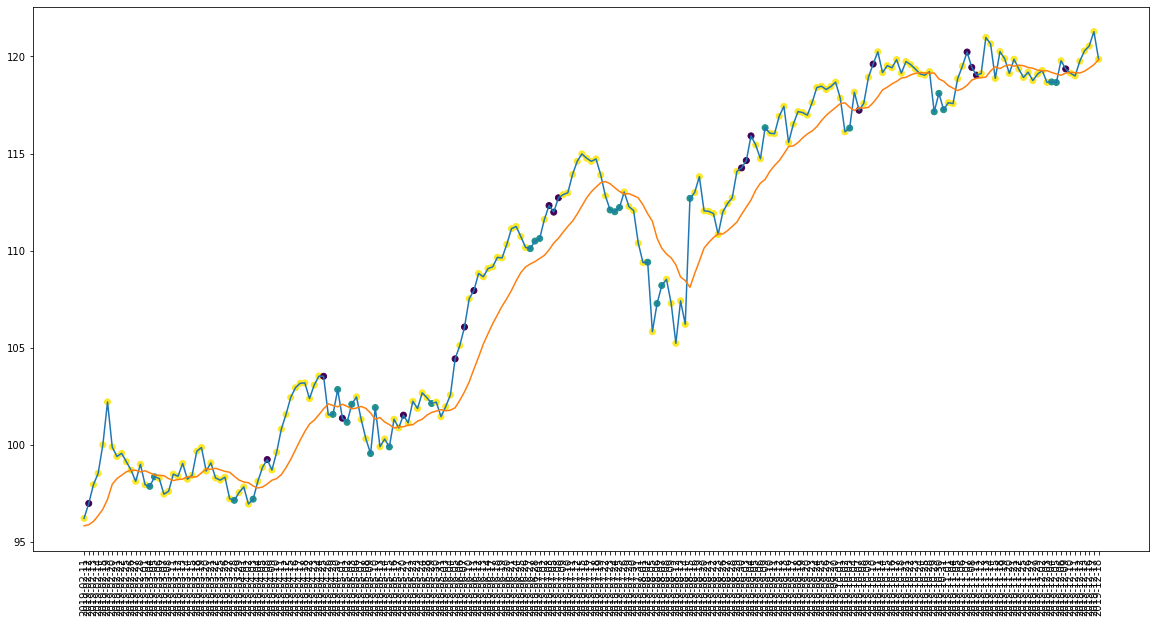

In [169]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

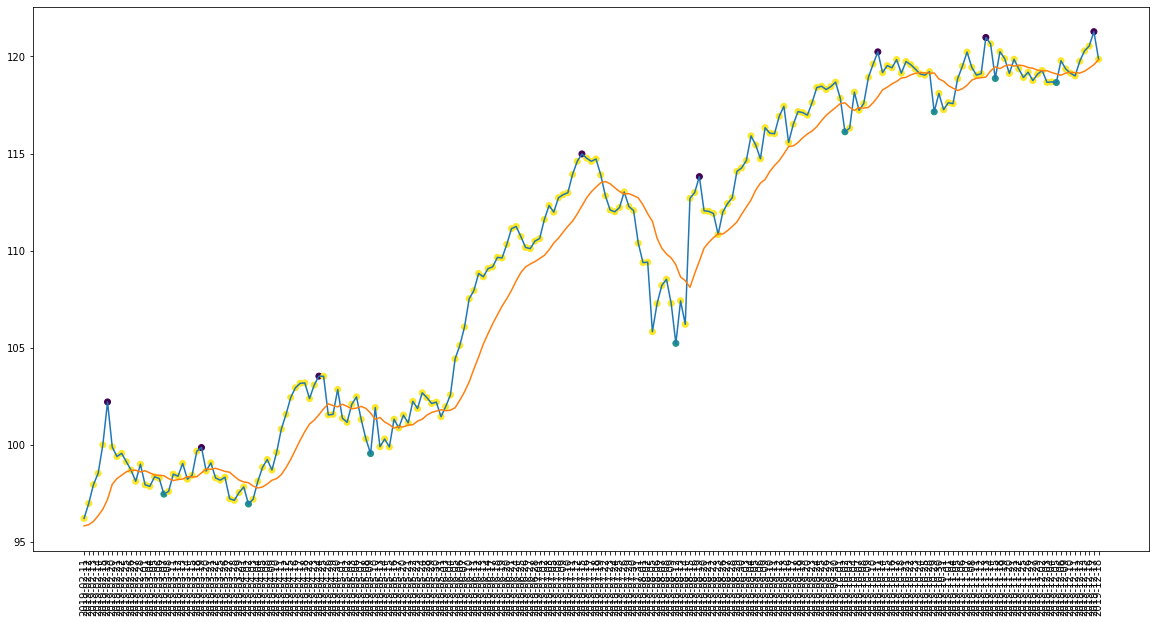

In [170]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [171]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 26
actual holds but predicted sell: 20
actual predicted holds: 156
Percentage buys correct: 37.5%
Percentage sells correct: 0.0%
Percentage holds correct: 77.22772277227723%
actual buys: 8
actual sells: 8
actual holds: 202


In [172]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 65.51724137931035%
Percentage sells correct: 40.0%
Percentage holds correct: 85.11904761904762%


In [173]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $97.8499984741211
Shares owned at the moment: 101
Cash capital at the moment: $89.97231703758189


Price increase from previously bought: 5.504444542825193%
Share price: $103.5199966430664
Shares owned at the moment: 0
Cash capital at the moment: $10516.739298919676


Share price: $101.55999755859376
Shares owned at the moment: 103
Cash capital at the moment: $27.292681076045483


Price increase from previously bought: 5.990531784129427%
Share price: $107.94000244140624
Shares owned at the moment: 0
Cash capital at the moment: $11114.538926849358


Share price: $110.0999984741211
Shares owned at the moment: 100
Cash capital at the moment: $74.26157985686586


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $10627.16104942321


Share price: $107.2699966430664
Shares owned at the moment: 98
Cash capital at the moment: $85.79211430739633


Price increase from previously bought: 6.224156257818758%
Share price: $1

In [174]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


In [175]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   
1       0.658654  33.333333333333336%                40.0%   
2       0.425121   45.45454545454545%                50.0%   
3       0.427885  42.857142857142854%                25.0%   
4       0.729358                37.5%                 0.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0   57.83783783783784%  43.333333333333336%  49.056603773584904%   
1   68.78306878306879%   77.77777777777777%  60.416666666666664%   
2  41.935483870967744%              59.375%   56.14035087719298%   
3  43.523316062176164%                60.0%   52.30769230769231%   
4   77.22772277227723%   65.51724137931035%                40.0%   

    correct_mid_holds        Profit gained    buy_n_hold profit  
0  81.30081300813008%  13.253565030822628%    53.5836826651001%  
1  85.81560283687944%   55.32266226867672%   66.41259749999998%  
2  78.82352941176471%   31.17646658102025%  24.380335833320625%  
3  80.43478260869566%  36.132353349885854%   64.87407351390837%  
4  85.11904761904762%  15.290049752502382%    23.7578138288879%

### Recession

In [176]:
logger = []

In [177]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   115.589996  116.459043 -80.074504 -17684500.0     2.0
2020-01-23   116.099998  116.403805 -70.577262 -12758400.0     2.0
2020-01-24   115.809998  116.312450 -69.789236 -17063500.0     2.0
2020-01-27   114.370003  116.013612 -94.416205 -21446900.0     2.0
2020-01-28   115.860001  115.989979 -34.297465 -14428500.0     2.0


In [178]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [179]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [180]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [181]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [182]:
model = tf.keras.models.load_model("models/walmart_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 3ms/step - loss: 0.1282 - accuracy: 0.7671 - mean_squared_error: 1.9859 - weighted_accuracy: 0.7671 - weighted_mean_squared_error: 1.9859
Test loss: 0.12817488610744476
Test accuracy: 0.767123281955719


In [183]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 175, 1: 28, 0: 16})

In [184]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [185]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)

In [186]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d      EMA_12   willr_14       OBV_7  labels  \
Date                                                                 
2020-02-11   115.400002  115.836459 -43.516528 -17373100.0     2.0   
2020-02-12   115.849998  115.769312 -40.219793 -11576300.0     2.0   
2020-02-13   117.440002  115.781725 -30.329757  -6840700.0     2.0   
2020-02-14   117.889999  116.036845  -2.057582  -1507500.0     2.0   
2020-02-18   119.629997  116.321946 -14.561040   6623100.0     0.0   

            predictions  actual  
Date                             
2020-02-11            2       2  
2020-02-12            2       2  
2020-02-13            2       2  
2020-02-14            2       2  
2020-02-18            2       0

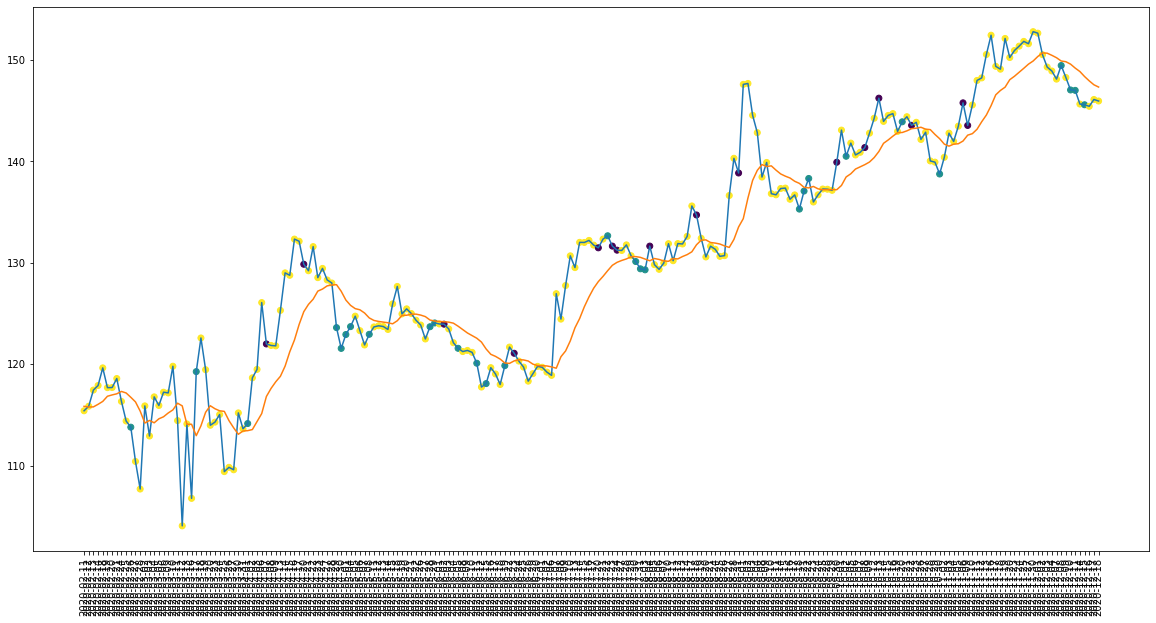

In [187]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

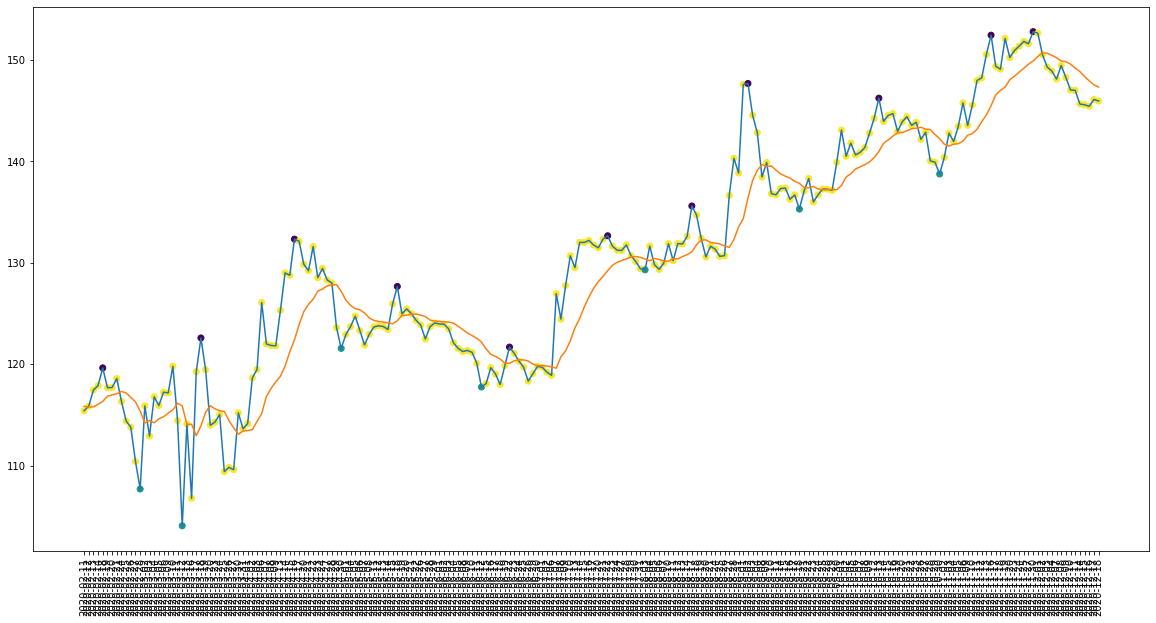

In [188]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [189]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 23
actual holds but predicted sell: 15
actual predicted holds: 163
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 81.09452736318408%
actual buys: 7
actual sells: 11
actual holds: 201


In [190]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 53.57142857142857%
Percentage sells correct: 50.0%
Percentage holds correct: 85.63218390804597%


In [191]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $113.77999877929688
Shares owned at the moment: 87
Cash capital at the moment: $73.91824149322565


Stop Loss Activated!

Share price: $110.4000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9652.305173879624


Share price: $119.26000213623048
Shares owned at the moment: 80
Cash capital at the moment: $85.26780251121272


Stop Loss Activated!

Share price: $113.97000122070312
Shares owned at the moment: 0
Cash capital at the moment: $9177.794499898908


Share price: $114.13999938964844
Shares owned at the moment: 80
Cash capital at the moment: $21.483748861310232


Price increase from previously bought: 6.5844104078232935%
Share price: $121.98999786376952
Shares owned at the moment: 0
Cash capital at the moment: $9753.845778432842


Share price: $123.5999984741211
Shares owned at the moment: 78
Cash capital at the moment: $86.53369777869739


Stop Loss Activated!

Share price: $120.08999633789062
Shares owned at the moment: 0
Cash capital at the momen

In [192]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


In [193]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   
1       0.658654  33.333333333333336%                40.0%   
2       0.425121   45.45454545454545%                50.0%   
3       0.427885  42.857142857142854%                25.0%   
4       0.729358                37.5%                 0.0%   
5       0.767123  57.142857142857146%   9.090909090909092%   

         correct_holds     correct_low_buys   correct_high_sells  \
0   57.83783783783784%  43.333333333333336%  49.056603773584904%   
1   68.78306878306879%   77.77777777777777%  60.416666666666664%   
2  41.935483870967744%              59.375%   56.14035087719298%   
3  43.523316062176164%                60.0%   52.30769230769231%   
4   77.22772277227723%   65.51724137931035%                40.0%   
5   81.09452736318408%   53.57142857142857%                50.0%   

    correct_mid_holds        Profit gained    buy_n_hold profit  
0  81.30081300813008%  13.253565030822628%    53.5836826651001%  
1  85.81560283687944%   55.32266226867672%   66.41259749999998%  
2  78.82352941176471%   31.17646658102025%  24.380335833320625%  
3  80.43478260869566%  36.132353349885854%   64.87407351390837%  
4  85.11904761904762%  15.290049752502382%    23.7578138288879%  
5  85.63218390804597%  11.163398889560613%   25.65490331684112%

## Fresh Del Monte Produce Inc

In [194]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


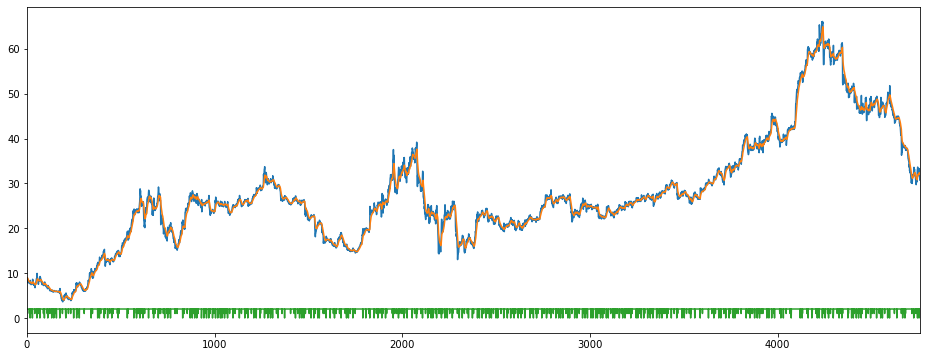

In [195]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [196]:
df.set_index('Date', inplace=True)
df.head()

previous_1d    EMA_12   willr_14     OBV_7  labels
Date                                                          
2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0

In [197]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1

In [198]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [200]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4745, 64, 64, 1)

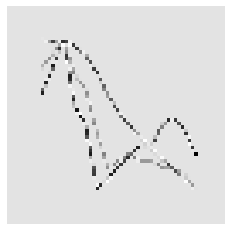

In [201]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [202]:
X = X/255

In [203]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [204]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [205]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [206]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [207]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.1893939393939394, 2: 0.3671890114142}
Epoch 1/200
30/30 [==============================] - 5s 162ms/step - loss: 0.2458 - accuracy: 0.3722 - mse: 1.6209 - weighted_accuracy: 0.3286 - weighted_mse: 1.7289 - val_loss: 0.2094 - val_accuracy: 0.0464 - val_mse: 1.0991 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 1.0991
Epoch 2/200
30/30 [==============================] - 1s 27ms/step - loss: 0.2049 - accuracy: 0.3396 - mse: 1.1644 - weighted_accuracy: 0.3737 - weighted_mse: 1.1861 - val_loss: 0.2016 - val_accuracy: 0.0569 - val_mse: 0.9207 - val_weighted_accuracy: 0.0569 - val_weighted_mse: 0.9207
Epoch 3/200
30/30 [==============================] - 1s 25ms/step - loss: 0.2032 - accuracy: 0.3936 - mse: 1.1605 - weighted_accuracy: 0.3574 - weighted_mse: 1.1768 - val_loss: 0.2002 - val_accuracy: 0.3614 - val_mse: 0.8665 - val_weighted_accuracy: 0.3614 - val_weighted_mse: 0.8665
Epoch 4/200
30/30 [==============================] - 1s 30ms/step - loss: 0.2043 

30/30 [==============================] - 1s 33ms/step - loss: 0.1990 - accuracy: 0.3348 - mse: 1.1682 - weighted_accuracy: 0.3561 - weighted_mse: 1.1678 - val_loss: 0.1964 - val_accuracy: 0.0664 - val_mse: 0.9854 - val_weighted_accuracy: 0.0664 - val_weighted_mse: 0.9854
Epoch 29/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1978 - accuracy: 0.3533 - mse: 1.1850 - weighted_accuracy: 0.3447 - weighted_mse: 1.1800 - val_loss: 0.1966 - val_accuracy: 0.1328 - val_mse: 0.9328 - val_weighted_accuracy: 0.1328 - val_weighted_mse: 0.9328
Epoch 30/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1978 - accuracy: 0.3367 - mse: 1.1765 - weighted_accuracy: 0.3551 - weighted_mse: 1.1766 - val_loss: 0.1957 - val_accuracy: 0.1222 - val_mse: 0.9611 - val_weighted_accuracy: 0.1222 - val_weighted_mse: 0.9611
Epoch 31/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1969 - accuracy: 0.3124 - mse: 1.1740 - weighted_accuracy: 0.3607 - weighted_mse:

Epoch 57/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1874 - accuracy: 0.2345 - mse: 1.2283 - weighted_accuracy: 0.4513 - weighted_mse: 1.1928 - val_loss: 0.1926 - val_accuracy: 0.1180 - val_mse: 1.0370 - val_weighted_accuracy: 0.1180 - val_weighted_mse: 1.0370
Epoch 58/200
30/30 [==============================] - 1s 31ms/step - loss: 0.1861 - accuracy: 0.2244 - mse: 1.2501 - weighted_accuracy: 0.4548 - weighted_mse: 1.2218 - val_loss: 0.1911 - val_accuracy: 0.1602 - val_mse: 1.0061 - val_weighted_accuracy: 0.1602 - val_weighted_mse: 1.0061
Epoch 59/200
30/30 [==============================] - 1s 30ms/step - loss: 0.1876 - accuracy: 0.2013 - mse: 1.2160 - weighted_accuracy: 0.4156 - weighted_mse: 1.1985 - val_loss: 0.1951 - val_accuracy: 0.0822 - val_mse: 1.0680 - val_weighted_accuracy: 0.0822 - val_weighted_mse: 1.0680
Epoch 60/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1848 - accuracy: 0.2158 - mse: 1.2538 - weighted_accuracy: 0.4751 - 

Epoch 86/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1731 - accuracy: 0.1944 - mse: 1.3282 - weighted_accuracy: 0.5143 - weighted_mse: 1.2652 - val_loss: 0.1940 - val_accuracy: 0.1180 - val_mse: 1.1391 - val_weighted_accuracy: 0.1180 - val_weighted_mse: 1.1391
Epoch 87/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1718 - accuracy: 0.1852 - mse: 1.3036 - weighted_accuracy: 0.5129 - weighted_mse: 1.2601 - val_loss: 0.1929 - val_accuracy: 0.1401 - val_mse: 1.1342 - val_weighted_accuracy: 0.1401 - val_weighted_mse: 1.1342
Epoch 88/200
30/30 [==============================] - 1s 32ms/step - loss: 0.1736 - accuracy: 0.1731 - mse: 1.2949 - weighted_accuracy: 0.5229 - weighted_mse: 1.2516 - val_loss: 0.1911 - val_accuracy: 0.1528 - val_mse: 1.1461 - val_weighted_accuracy: 0.1528 - val_weighted_mse: 1.1461
Epoch 89/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1713 - accuracy: 0.1694 - mse: 1.3337 - weighted_accuracy: 0.5325 - 

Epoch 115/200
30/30 [==============================] - 1s 36ms/step - loss: 0.1507 - accuracy: 0.2579 - mse: 1.4813 - weighted_accuracy: 0.6281 - weighted_mse: 1.4546 - val_loss: 0.1895 - val_accuracy: 0.2740 - val_mse: 1.3709 - val_weighted_accuracy: 0.2740 - val_weighted_mse: 1.3709
Epoch 116/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1488 - accuracy: 0.2505 - mse: 1.5335 - weighted_accuracy: 0.6470 - weighted_mse: 1.4927 - val_loss: 0.1946 - val_accuracy: 0.2392 - val_mse: 1.3896 - val_weighted_accuracy: 0.2392 - val_weighted_mse: 1.3896
Epoch 117/200
30/30 [==============================] - 1s 35ms/step - loss: 0.1475 - accuracy: 0.2484 - mse: 1.5248 - weighted_accuracy: 0.6481 - weighted_mse: 1.4841 - val_loss: 0.1904 - val_accuracy: 0.2824 - val_mse: 1.4730 - val_weighted_accuracy: 0.2824 - val_weighted_mse: 1.4730
Epoch 118/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1475 - accuracy: 0.2674 - mse: 1.6006 - weighted_accuracy: 0.644

Epoch 144/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1296 - accuracy: 0.4257 - mse: 1.7571 - weighted_accuracy: 0.7257 - weighted_mse: 1.8231 - val_loss: 0.1835 - val_accuracy: 0.3983 - val_mse: 1.6205 - val_weighted_accuracy: 0.3983 - val_weighted_mse: 1.6205
Epoch 145/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1303 - accuracy: 0.4323 - mse: 1.8763 - weighted_accuracy: 0.7209 - weighted_mse: 1.9837 - val_loss: 0.1750 - val_accuracy: 0.4573 - val_mse: 1.6909 - val_weighted_accuracy: 0.4573 - val_weighted_mse: 1.6909
Epoch 146/200
30/30 [==============================] - 1s 34ms/step - loss: 0.1286 - accuracy: 0.4268 - mse: 1.8289 - weighted_accuracy: 0.7098 - weighted_mse: 1.9544 - val_loss: 0.1766 - val_accuracy: 0.4194 - val_mse: 1.5800 - val_weighted_accuracy: 0.4194 - val_weighted_mse: 1.5800
Epoch 147/200
30/30 [==============================] - 1s 33ms/step - loss: 0.1262 - accuracy: 0.4515 - mse: 1.8602 - weighted_accuracy: 0.737

Epoch 173/200
30/30 [==============================] - 1s 23ms/step - loss: 0.1154 - accuracy: 0.5411 - mse: 2.1400 - weighted_accuracy: 0.7608 - weighted_mse: 2.4115 - val_loss: 0.1581 - val_accuracy: 0.6006 - val_mse: 1.6651 - val_weighted_accuracy: 0.6006 - val_weighted_mse: 1.6651
Epoch 174/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1190 - accuracy: 0.5527 - mse: 2.0452 - weighted_accuracy: 0.7341 - weighted_mse: 2.3037 - val_loss: 0.1585 - val_accuracy: 0.5796 - val_mse: 1.8053 - val_weighted_accuracy: 0.5796 - val_weighted_mse: 1.8053
Epoch 175/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1173 - accuracy: 0.5548 - mse: 2.1871 - weighted_accuracy: 0.7332 - weighted_mse: 2.4589 - val_loss: 0.1586 - val_accuracy: 0.5911 - val_mse: 1.7873 - val_weighted_accuracy: 0.5911 - val_weighted_mse: 1.7873
Epoch 176/200
30/30 [==============================] - 1s 24ms/step - loss: 0.1106 - accuracy: 0.5603 - mse: 2.1871 - weighted_accuracy: 0.766

In [208]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

Test loss: 0.1343076229095459
Test accuracy: 0.7397260069847107


In [209]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.5545688  -1.1980482  -0.00987124]
 [-0.5996288  -1.6620655  -0.24696666]
 [-0.47542864 -2.1734538  -0.33678576]
 ...
 [-2.0276566  -0.2052962  -0.5779437 ]
 [-0.47504598 -2.2111845  -0.33852097]
 [-0.65860337 -1.9255302  -0.18414715]]


Counter({2: 748, 0: 85, 1: 116})

In [210]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [211]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 13
actual buys but predicted sell: 3
actual buys but predicted hold: 28
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 37
actual holds but predicted buy: 103
actual holds but predicted sell: 76
actual predicted holds: 683
Percentage buys correct: 29.545454545454547%
Percentage sells correct: 13.953488372093023%
Percentage holds correct: 79.23433874709977%
actual buys: 44
actual sells: 43
actual holds: 862


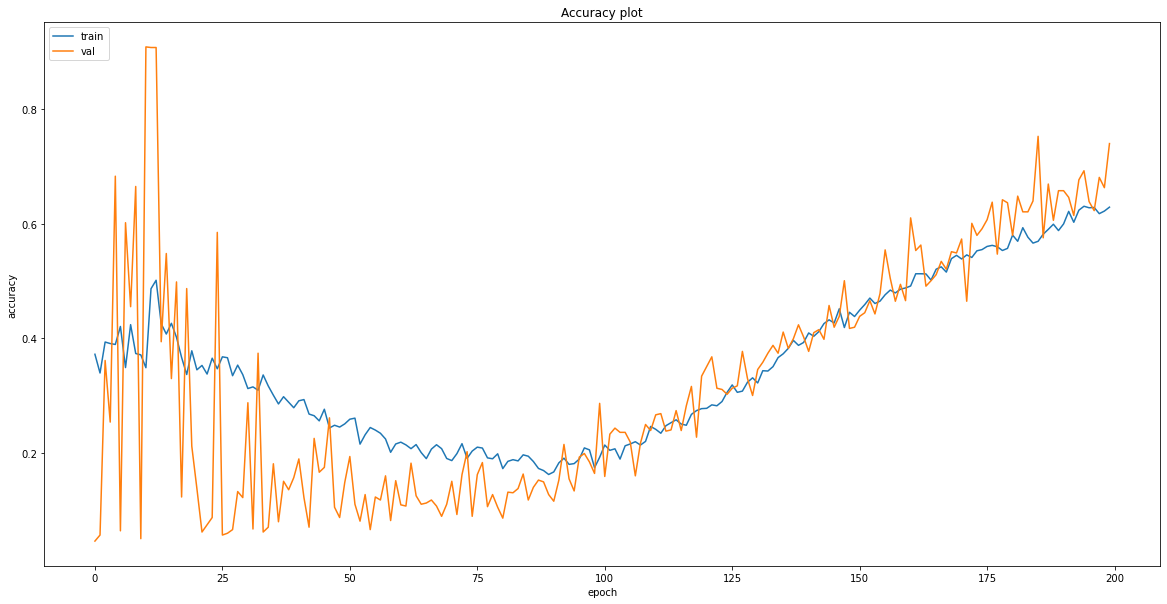

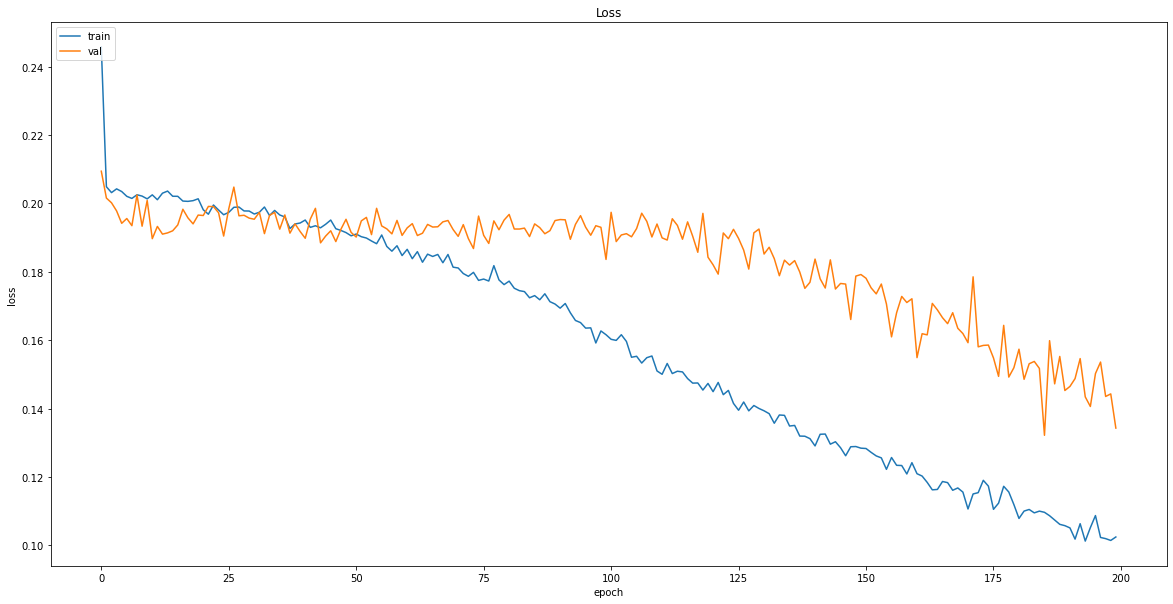

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [213]:
# Save model
model.save("models/{}".format('FDP_image_cnn_buy_hold_sell_no_obv.model'))

INFO:tensorflow:Assets written to: models/FDP_image_cnn_buy_hold_sell_no_obv.model\assets


### Test Performance

### non-recession

In [214]:
logger = []

In [215]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2019-01-22    30.219999  29.918096 -32.033467  1515700.0     2.0
2019-01-23    30.480000  30.004543 -24.791121  1646600.0     2.0
2019-01-24    30.459999  30.074613 -28.980936  1528300.0     2.0
2019-01-25    30.639999  30.161596 -35.265743  1632300.0     2.0
2019-01-28    30.879999  30.272119 -23.671560  1731100.0     2.0


In [216]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [218]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [219]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [220]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 8ms/step - loss: 0.1386 - accuracy: 0.7294 - mean_squared_error: 1.8759 - weighted_accuracy: 0.7294 - weighted_mean_squared_error: 1.8759
Test loss: 0.13855789601802826
Test accuracy: 0.7293577790260315


In [221]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 23, 2: 172, 1: 23})

In [222]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [223]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)

In [224]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14      OBV_7  labels  predictions  \
Date                                                                            
2019-02-11    33.880001  31.978904  -0.753738  2502700.0     2.0            0   
2019-02-12    34.610001  32.271381  -0.536205  2611700.0     2.0            2   
2019-02-13    34.810001  32.631168  -5.603413  2713000.0     2.0            2   
2019-02-14    34.430000  32.966373  -5.668932  2794100.0     2.0            2   
2019-02-15    35.220001  33.191547 -14.285733  2675800.0     0.0            2   

            actual  
Date                
2019-02-11       2  
2019-02-12       2  
2019-02-13       2  
2019-02-14       2  
2019-02-15       0

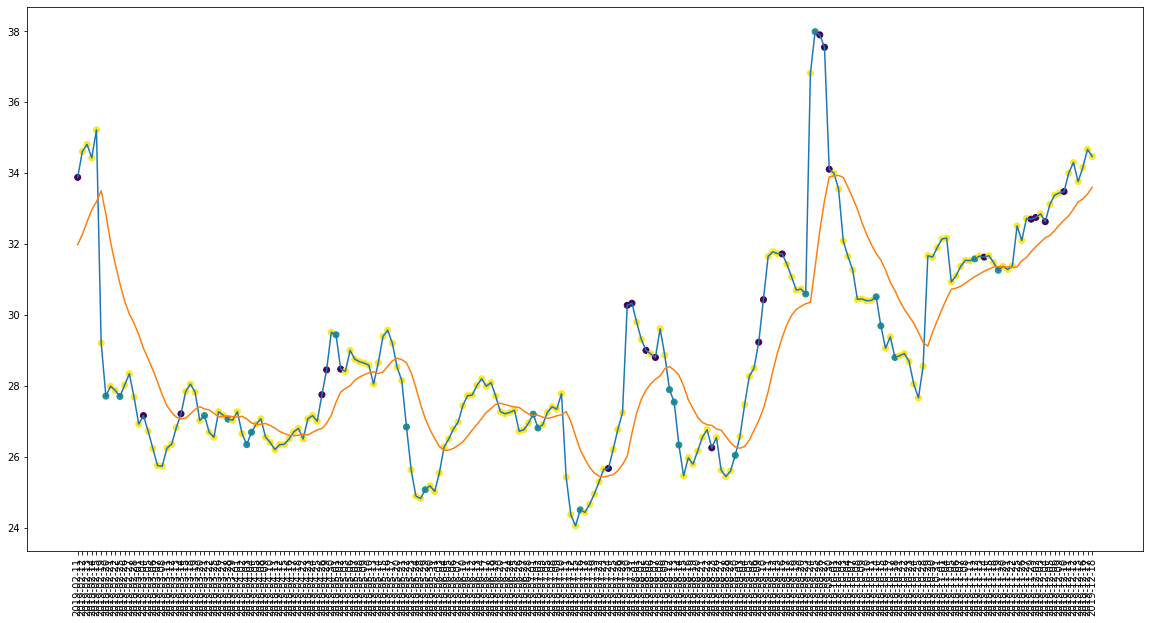

In [225]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

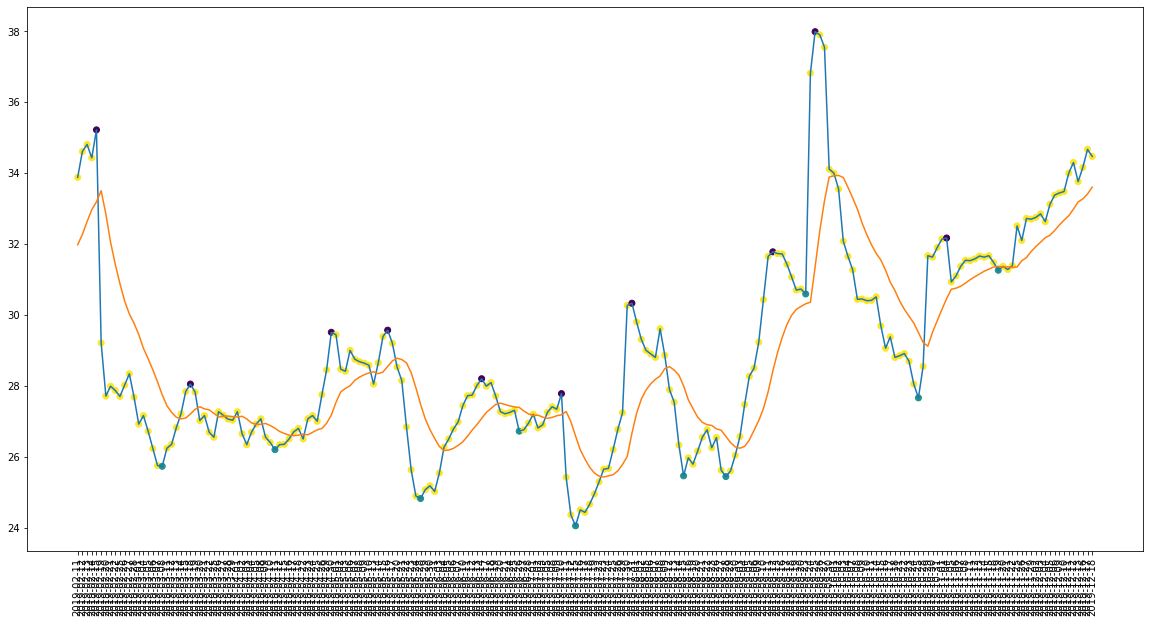

In [226]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [227]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 20
actual holds but predicted sell: 22
actual predicted holds: 156
Percentage buys correct: 20.0%
Percentage sells correct: 10.0%
Percentage holds correct: 78.78787878787878%
actual buys: 10
actual sells: 10
actual holds: 198


In [228]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 47.82608695652174%
Percentage sells correct: 47.82608695652174%
Percentage holds correct: 83.62573099415205%


In [229]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.709999084472656
Shares owned at the moment: 359
Cash capital at the moment: $24.753632078170995


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9662.456889392375


Share price: $27.15999984741211
Shares owned at the moment: 354
Cash capital at the moment: $21.376683557033175


Stop Loss Activated!

Share price: $26.34000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9320.094747424602


Share price: $26.34000015258789
Shares owned at the moment: 352
Cash capital at the moment: $22.917573565959174


Price increase from previously bought: 5.064148153110337%
Share price: $27.75
Shares owned at the moment: 0
Cash capital at the moment: $9764.055573565958


Share price: $29.440000534057607
Shares owned at the moment: 330
Cash capital at the moment: $22.138596842291008


Stop Loss Activated!

Share price: $28.46999931335449
Shares owned at the moment: 0
Cash capital at the moment: $9391.

In [230]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


In [231]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   
1       0.658654  33.333333333333336%                40.0%   
2       0.425121   45.45454545454545%                50.0%   
3       0.427885  42.857142857142854%                25.0%   
4       0.729358                37.5%                 0.0%   
5       0.767123  57.142857142857146%   9.090909090909092%   
6       0.729358                20.0%                10.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0   57.83783783783784%  43.333333333333336%  49.056603773584904%   
1   68.78306878306879%   77.77777777777777%  60.416666666666664%   
2  41.935483870967744%              59.375%   56.14035087719298%   
3  43.523316062176164%                60.0%   52.30769230769231%   
4   77.22772277227723%   65.51724137931035%                40.0%   
5   81.09452736318408%   53.57142857142857%                50.0%   
6   78.78787878787878%   47.82608695652174%   47.82608695652174%   

    correct_mid_holds        Profit gained    buy_n_hold profit  
0  81.30081300813008%  13.253565030822628%    53.5836826651001%  
1  85.81560283687944%   55.32266226867672%   66.41259749999998%  
2  78.82352941176471%   31.17646658102025%  24.380335833320625%  
3  80.43478260869566%  36.132353349885854%   64.87407351390837%  
4  85.11904761904762%  15.290049752502382%    23.7578138288879%  
5  85.63218390804597%  11.163398889560613%   25.65490331684112%  
6  83.62573099415205%   25.38663184563626%  1.1819906801032993%

### recession

In [232]:
logger = []

In [233]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2020-01-22    34.250000  34.338683 -60.666656  -55800.0     2.0
2020-01-23    34.130001  34.306578 -67.360995 -191000.0     2.0
2020-01-24    34.520000  34.339413 -36.764689   18500.0     2.0
2020-01-27    32.290001  34.024118 -98.555924 -130500.0     2.0
2020-01-28    32.160000  33.737331 -85.885906 -280200.0     2.0


In [234]:
willr_data = []
price_data = []
ema_data = []
#obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
#data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        #data_15_obv_arr = min_max_scaler.fit_transform(#data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        #obv_data.append(#data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        #data_15_obv = #data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        #data_15_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
#obv_data = np.array(#obv_data)

In [235]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    #m = #obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    #ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [236]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [237]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [238]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_no_obv.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 5ms/step - loss: 0.1309 - accuracy: 0.7306 - mean_squared_error: 1.9978 - weighted_accuracy: 0.7306 - weighted_mean_squared_error: 1.9978
Test loss: 0.1309153288602829
Test accuracy: 0.7305936217308044


In [239]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 176, 1: 23, 0: 20})

In [240]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [241]:
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)

In [242]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

previous_1d     EMA_12   willr_14     OBV_7  labels  predictions  \
Date                                                                           
2020-02-11    33.930000  32.680842 -26.373606  310600.0     2.0            2   
2020-02-12    34.410000  32.873020 -19.505473  431300.0     2.0            2   
2020-02-13    34.240002  33.109478 -14.750004  582800.0     2.0            2   
2020-02-14    34.480000  33.283405 -18.999958  490800.0     0.0            2   
2020-02-18    34.009998  33.467496 -13.000011  587800.0     2.0            2   

            actual  
Date                
2020-02-11       2  
2020-02-12       2  
2020-02-13       2  
2020-02-14       0  
2020-02-18       2

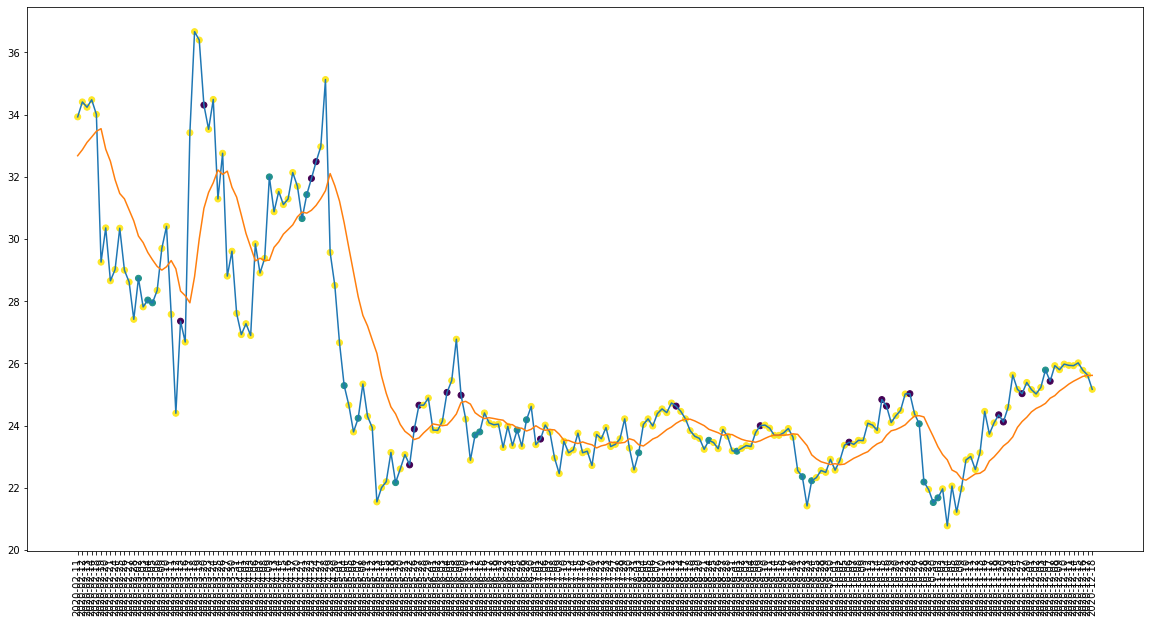

In [243]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

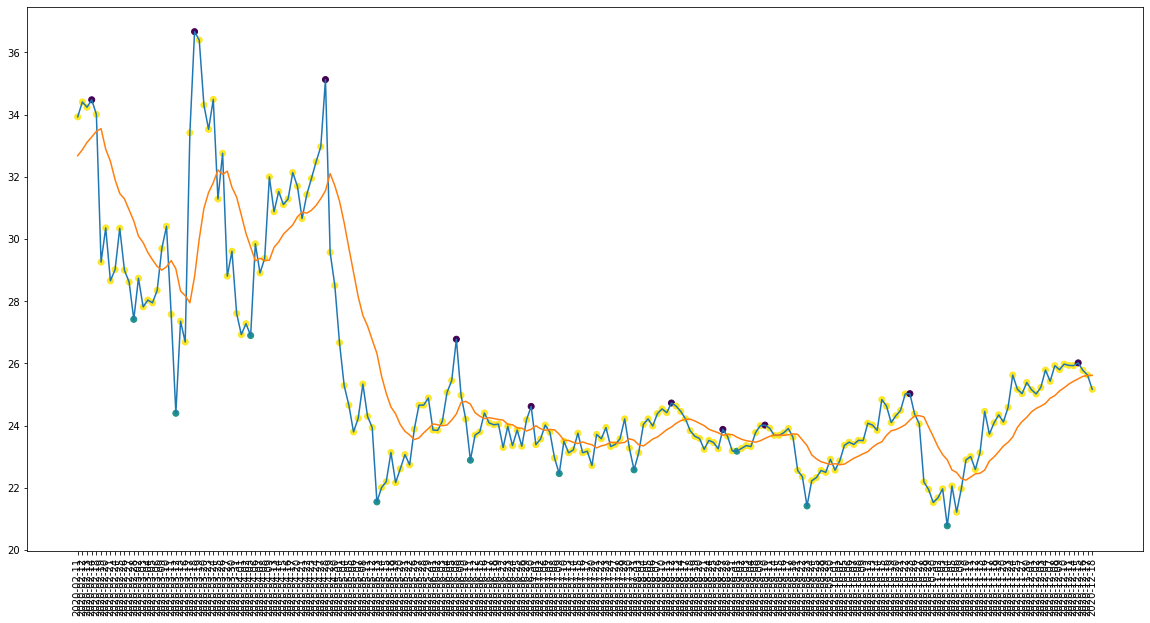

In [244]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [245]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 22
actual holds but predicted sell: 19
actual predicted holds: 158
Percentage buys correct: 10.0%
Percentage sells correct: 10.0%
Percentage holds correct: 79.39698492462311%
actual buys: 10
actual sells: 10
actual holds: 199


In [246]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 69.56521739130434%
Percentage sells correct: 60.0%
Percentage holds correct: 81.14285714285714%


In [247]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.739999771118164
Shares owned at the moment: 346
Cash capital at the moment: $28.61396941089515


Stop Loss Activated!

Share price: $27.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9627.86313411045


Share price: $28.040000915527344
Shares owned at the moment: 342
Cash capital at the moment: $11.811200139045468


Stop Loss Activated!

Share price: $24.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $8333.66287003517


Share price: $32.0
Shares owned at the moment: 259
Cash capital at the moment: $22.87087003517081


Stop Loss Activated!

Share price: $30.8799991607666
Shares owned at the moment: 0
Cash capital at the moment: $7998.796373271464


Share price: $30.65999984741211
Shares owned at the moment: 260
Cash capital at the moment: $5.274513053415831


Price increase from previously bought: 5.678080126885887%
Share price: $32.490001678466804
Shares owned at the moment: 0
Cash capital at the moment: $8429.444598

In [248]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%


In [249]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

Test_accuracy         correct_buys        correct_sells  \
0       0.541063  18.181818181818183%  27.272727272727273%   
1       0.658654  33.333333333333336%                40.0%   
2       0.425121   45.45454545454545%                50.0%   
3       0.427885  42.857142857142854%                25.0%   
4       0.729358                37.5%                 0.0%   
5       0.767123  57.142857142857146%   9.090909090909092%   
6       0.729358                20.0%                10.0%   
7       0.730594                10.0%                10.0%   

         correct_holds     correct_low_buys   correct_high_sells  \
0   57.83783783783784%  43.333333333333336%  49.056603773584904%   
1   68.78306878306879%   77.77777777777777%  60.416666666666664%   
2  41.935483870967744%              59.375%   56.14035087719298%   
3  43.523316062176164%                60.0%   52.30769230769231%   
4   77.22772277227723%   65.51724137931035%                40.0%   
5   81.09452736318408%   53.57142857142857%                50.0%   
6   78.78787878787878%   47.82608695652174%   47.82608695652174%   
7   79.39698492462311%   69.56521739130434%                60.0%   

    correct_mid_holds         Profit gained    buy_n_hold profit  
0  81.30081300813008%   13.253565030822628%    53.5836826651001%  
1  85.81560283687944%    55.32266226867672%   66.41259749999998%  
2  78.82352941176471%    31.17646658102025%  24.380335833320625%  
3  80.43478260869566%   36.132353349885854%   64.87407351390837%  
4  85.11904761904762%   15.290049752502382%    23.7578138288879%  
5  85.63218390804597%   11.163398889560613%   25.65490331684112%  
6  83.62573099415205%    25.38663184563626%  1.1819906801032993%  
7  81.14285714285714%  -39.987332455010424%  -26.14299892369747%

In [250]:
experiment

'No OBV CNN Images Experiments - noncyclic'

In [251]:
log.to_csv('{}.csv'.format(experiment))